# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


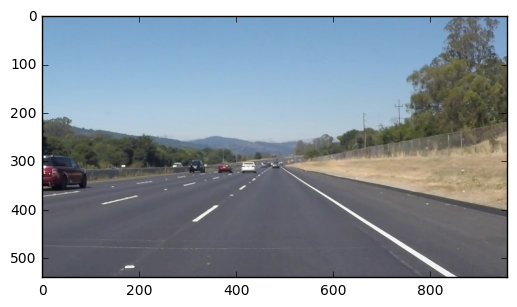

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [74]:
#   Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:
#
#   cv2.inRange()         for color selection
#
#       http://docs.opencv.org/2.4/modules/core/doc/operations_on_arrays.html?highlight=inrange#cv2.inRange
#
#
#   cv2.fillPoly()        for regions selection
#
#       http://docs.opencv.org/2.4/modules/core/doc/drawing_functions.html?highlight=fillpoly#cv2.fillPoly
#
#
#   cv2.line()            to draw lines on an image given endpoints
#
#       http://docs.opencv.org/2.4/modules/core/doc/drawing_functions.html?highlight=line#cv2.line
#
#
#   cv2.addWeighted()     to coadd / overlay two images cv2.cvtColor() to grayscale or change color cv2.imwrite() to
#                           output images to file
#
#       http://docs.opencv.org/2.4/modules/core/doc/operations_on_arrays.html?highlight=addweighted#cv2.addWeighted
#
#
#   cv2.bitwise_and()     to apply a mask to an image
#
#       http://docs.opencv.org/2.4/modules/core/doc/operations_on_arrays.html?highlight=bitwise_and#cv2.bitwise_and
#
#
#   Check out the OpenCV documentation to learn about these and discover even more awesome functionality!
#
#
#   Below are some helper functions to help get you started. They should look familiar from the lesson!
#
#   from helpers import FUNCTION_NAME

import math


def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)


def gaussian_noise(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)


def region_of_interest(img, vertices):
    """
    Applies an image mask.

    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    # defining a blank mask to start with
    mask = np.zeros_like(img)

    # defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    # filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    # returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


alp = 0.25
l_prev_x1 = l_prev_y1 = l_prev_y2 = l_prev_x2 = l_abs_min_y = None
r_prev_x1 = r_prev_y1 = r_prev_y2 = r_prev_x2 = r_abs_min_y = None


def draw_left_line(img, lines, color=[255, 0, 0], thickness=15):
    global l_prev_x1, l_prev_y1, l_prev_y2, l_prev_x2, l_abs_min_y

    abs_max_y = img.shape[0]

    # draw left line
    all_x1 = []
    all_y1 = []
    left_y2 = []
    left_slopes = []
    left_intercepts = []

    for x1, y1, x2, y2, angle, m, b in lines:
        all_x1.append(x1)
        all_y1.append(y1)
        left_y2.append(y2)
        left_slopes.append(m)
        left_intercepts.append(b)

    # Find the average of all slopes and y-intercepts to essentially center the final line along the lane line
    m = sum(left_slopes) / len(left_slopes)
    b = sum(left_intercepts) / len(left_intercepts)

    # Smooth out our y2 by remembering the smallest y2
    # doesn't work well on curves at which point I would switch to a
    # different algorithm for curve analysis
    if l_abs_min_y is None:
        l_abs_min_y = min(left_y2)
    y2 = min(l_abs_min_y, min(left_y2))
    l_abs_min_y = y2

    # x1 = int((abs_max_y - b) / m)
    # x1 = min(all_x1)
    y1 = abs_max_y
    x1 = int((y1 - b) / m)
    x2 = int((y2 - b) / m)

    if l_prev_y1 is None:
        alp = 1
    else:
        alp = 0.1
        
    # Smooth out the line
    if l_prev_y1 is not None:
        y1 = int(l_prev_y1 * (1 - alp) + y1 * alp)

    if l_prev_y2 is not None:
        y2 = int(l_prev_y2 * (1 - alp) + y2 * alp)

    if l_prev_x1 is not None:
        x1 = int(l_prev_x1 * (1 - alp) + x1 * alp)

    if l_prev_x2 is not None:
        x2 = int(l_prev_x2 * (1 - alp) + x2 * alp)

    cv2.line(img, (x1, y1), (x2, y2), color, thickness)

    # keep our globals updated
    l_prev_y1 = y1
    l_prev_y2 = y2
    l_prev_x1 = x1
    l_prev_x2 = x2


def draw_right_line(img, lines, color=[255, 0, 0], thickness=15):
    global r_prev_x1, r_prev_y1, r_prev_y2, r_prev_x2, r_abs_min_y

    abs_max_y = img.shape[0]

    # draw left line
    all_y1 = []
    slopes = []
    intercepts = []

    for x1, y1, x2, y2, angle, m, b in lines:
        all_y1.append(y1)
        slopes.append(m)
        intercepts.append(b)

    # Find the average of all slopes and y-intercepts to essentially center the final line along the lane line
    m = sum(slopes) / len(slopes)
    b = sum(intercepts) / len(intercepts)

    # Smooth out our y1 by remembering the smallest y1
    # doesn't work well on curves at which point I would switch to a
    # different algorithm for curve analysis

    if r_abs_min_y is None:
        r_abs_min_y = min(all_y1)
    y1 = min(r_abs_min_y, min(all_y1))
    r_abs_min_y = y1

    x1 = int((r_abs_min_y - b) / m)
    y2 = abs_max_y
    x2 = int((y2 - b) / m)
    
    if r_prev_y1 is None:
        alp = 1
    else:
        alp = 0.1   
    
    # Smooth out the line
    if r_prev_y1 is not None:
        y1 = int(r_prev_y1 * (1 - alp) + y1 * alp)

    if r_prev_y2 is not None:
        y2 = int(r_prev_y2 * (1 - alp) + y2 * alp)

    if r_prev_x1 is not None:
        x1 = int(r_prev_x1 * (1 - alp) + x1 * alp)

    if r_prev_x2 is not None:
        x2 = int(r_prev_x2 * (1 - alp) + x2 * alp)

    cv2.line(img, (x1, y1), (x2, y2), color, thickness)

    # keep our globals updated
    r_prev_y1 = y1
    r_prev_y2 = y2
    r_prev_x1 = x1
    r_prev_x2 = x2


def draw_lines(img, lines, color=[255, 0, 0], thickness=15):
    """
    NOTE: this is the function you might want to use as a starting point once you want to
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).

    Think about things like separating line segments by their
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of
    the lines and extrapolate to the top and bottom of the lane.

    This function draws `lines` with `color` and `thickness`.
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """

    if lines is None or len(lines) <= 0:
        return

    left_lane_lines = []
    right_lane_lines = []

    # This iteration splits each line into their respective line side bucket.
    # Negative line angles are left lane lines
    # Positive line angles are right lane lines
    # We also filter out outlier lines such as horizontal lines by specifying a
    # range of acceptable angles. There is definitely a better way but I feel
    # this is accurate enough for first pass.
    for line in lines:
        for x1, y1, x2, y2 in line:

            # compute the angle of the line
            angle = math.atan2(y2 - y1, x2 - x1) * 180.0 / np.pi
            m = (y2 - y1) / (x2 - x1)
            b = y1 - m * x1

            # left lane line
            if -40 < angle <= -30:
                print('left (x1, y1, x2, y2, angle, m, b) ', x1, y1, x2, y2, angle, m, b)
                left_lane_lines.append(tuple((x1, y1, x2, y2, angle, m, b)))

            # right lane line
            elif 28 <= angle <= 45:
                right_lane_lines.append(tuple((x1, y1, x2, y2, angle, m, b)))
            else:
                if len(right_lane_lines) > 0:
                    right_lane_lines.append(right_lane_lines[len(right_lane_lines) - 1])
                if len(left_lane_lines) > 0:
                    left_lane_lines.append(left_lane_lines[len(left_lane_lines) - 1])

    if len(left_lane_lines) > 0:
        draw_left_line(img, left_lane_lines, color, thickness)

    if len(right_lane_lines) > 0:
        draw_right_line(img, right_lane_lines, color, thickness)


def hough_lines(orig_img, img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.

    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len,
                            maxLineGap=max_line_gap)
    # line_img = np.zeros(img.shape, dtype=np.uint8)
    line_img = np.copy(orig_img) * 0  # creating a blank to draw lines on

    draw_lines(line_img, lines)
    return line_img


# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.

    `initial_img` should be the image before any processing.

    The result image is computed as follows:

    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [75]:
import os
os.listdir("test_images/")

['horzLineTest.jpg',
 'solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

run your solution on all test_images and make copies into the test_images directory).

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [62]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [63]:
def process_image(image):
    # call as plt.imshow(gray, cmap='gray') to show a grayscaled image
    gray = grayscale(image)
    # plt.imshow(gray, cmap='gray')
    # plt.show()

    # Define a kernel size for Gaussian smoothing / blurring
    kernel_size = 5  # Must be an odd number (3, 5, 7...)
    blur_gray = gaussian_noise(gray, kernel_size)

    # Define our parameters for Canny and run it
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)

    # Display the image
    # plt.imshow(edges, cmap='Greys_r')
    # plt.show()


    # region mask

    # This time we are defining a four sided polygon to mask
    imshape = image.shape

    bottom_offset = 55
    img_height = imshape[0]
    img_width = imshape[1]

    # (W, H) == (x, y)
    vertices = np.array([
        [
            (bottom_offset, img_height),  # bottom left
            (img_width * 0.48, img_height * 0.60),  # top left
            (img_width * 0.54, img_height * 0.60),  # top right
            (img_width - bottom_offset, img_height)  # bottom right
        ]
    ], dtype=np.int32)

    # print('region of interest vertices: ', vertices)

    masked_edges = region_of_interest(edges, vertices)

    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    #
    # Defaults:
    # rho = 1
    # theta = np.pi/180
    # threshold = 1
    # min_line_length = 10
    # max_line_gap = 1

    rho = 2
    theta = np.pi / 180
    threshold = 40
    min_line_length = 20
    max_line_gap = 50

    result = hough_lines(image, masked_edges, rho, theta, threshold, min_line_length, max_line_gap)

    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((edges, edges, edges))

    α = 0.8
    β = 1.
    λ = 0.
    result = weighted_img(result, image, α, β, λ)

    return result

Let's try the one with the solid white lane on the right first ...

In [76]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

left (x1, y1, x2, y2, angle, m, b)  200 515 310 432 -37.03621293928123 -0.754545454545 665.909090909
left (x1, y1, x2, y2, angle, m, b)  188 511 303 430 -35.158868240365614 -0.704347826087 643.417391304
left (x1, y1, x2, y2, angle, m, b)  358 388 418 346 -34.992020198558656 -0.7 638.6
left (x1, y1, x2, y2, angle, m, b)  213 507 307 434 -37.83276127148024 -0.776595744681 672.414893617
left (x1, y1, x2, y2, angle, m, b)  361 391 431 342 -34.992020198558656 -0.7 643.7
left (x1, y1, x2, y2, angle, m, b)  187 512 304 430 -35.02487327954136 -0.700854700855 643.05982906
left (x1, y1, x2, y2, angle, m, b)  275 448 302 430 -33.690067525979785 -0.666666666667 631.333333333
[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


  4%|▎         | 8/222 [00:00<00:02, 79.09it/s]

left (x1, y1, x2, y2, angle, m, b)  200 515 310 432 -37.03621293928123 -0.754545454545 665.909090909
left (x1, y1, x2, y2, angle, m, b)  188 511 303 430 -35.158868240365614 -0.704347826087 643.417391304
left (x1, y1, x2, y2, angle, m, b)  358 388 418 346 -34.992020198558656 -0.7 638.6
left (x1, y1, x2, y2, angle, m, b)  213 507 307 434 -37.83276127148024 -0.776595744681 672.414893617
left (x1, y1, x2, y2, angle, m, b)  361 391 431 342 -34.992020198558656 -0.7 643.7
left (x1, y1, x2, y2, angle, m, b)  187 512 304 430 -35.02487327954136 -0.700854700855 643.05982906
left (x1, y1, x2, y2, angle, m, b)  275 448 302 430 -33.690067525979785 -0.666666666667 631.333333333
left (x1, y1, x2, y2, angle, m, b)  170 538 289 448 -37.10030838573477 -0.756302521008 666.571428571
left (x1, y1, x2, y2, angle, m, b)  151 538 277 447 -35.83765295427829 -0.722222222222 647.055555556
left (x1, y1, x2, y2, angle, m, b)  355 398 433 339 -37.10423490570622 -0.75641025641 666.525641026
left (x1, y1, x2, y2, angl

 12%|█▏        | 26/222 [00:00<00:02, 79.90it/s]

left (x1, y1, x2, y2, angle, m, b)  358 392 422 347 -35.11201118442221 -0.703125 643.71875
left (x1, y1, x2, y2, angle, m, b)  350 390 426 344 -31.184974658738387 -0.605263157895 601.842105263
left (x1, y1, x2, y2, angle, m, b)  339 400 423 347 -32.24997416418363 -0.630952380952 613.892857143
left (x1, y1, x2, y2, angle, m, b)  346 402 423 348 -35.04192940153902 -0.701298701299 644.649350649
left (x1, y1, x2, y2, angle, m, b)  335 412 448 330 -35.967030301028906 -0.725663716814 655.097345133
left (x1, y1, x2, y2, angle, m, b)  326 411 415 349 -34.86219614691487 -0.696629213483 638.101123596
left (x1, y1, x2, y2, angle, m, b)  310 423 449 330 -33.78508531534643 -0.669064748201 630.410071942
left (x1, y1, x2, y2, angle, m, b)  321 424 456 326 -35.97687028710933 -0.725925925926 657.022222222
left (x1, y1, x2, y2, angle, m, b)  333 415 416 351 -37.635253755017345 -0.771084337349 671.771084337
left (x1, y1, x2, y2, angle, m, b)  311 422 341 401 -34.992020198558656 -0.7 639.7
left (x1, y1, x

 19%|█▉        | 42/222 [00:00<00:02, 77.55it/s]

left (x1, y1, x2, y2, angle, m, b)  267 452 448 330 -33.98127609600107 -0.674033149171 631.966850829
left (x1, y1, x2, y2, angle, m, b)  277 455 415 355 -35.92850242282283 -0.724637681159 655.724637681
left (x1, y1, x2, y2, angle, m, b)  248 478 376 385 -36.00074895416071 -0.7265625 658.1875
left (x1, y1, x2, y2, angle, m, b)  235 476 411 358 -33.84005613496725 -0.670454545455 633.556818182
left (x1, y1, x2, y2, angle, m, b)  368 383 446 331 -33.690067525979785 -0.666666666667 628.333333333
left (x1, y1, x2, y2, angle, m, b)  236 475 318 418 -34.80401175271321 -0.69512195122 639.048780488
left (x1, y1, x2, y2, angle, m, b)  244 478 328 419 -35.08347387909274 -0.702380952381 649.380952381
left (x1, y1, x2, y2, angle, m, b)  209 508 433 339 -37.033249390029304 -0.754464285714 665.683035714
left (x1, y1, x2, y2, angle, m, b)  361 392 408 360 -34.249033006811956 -0.68085106383 637.787234043
left (x1, y1, x2, y2, angle, m, b)  191 508 303 430 -34.85445556610366 -0.696428571429 641.017857143

 25%|██▌       | 56/222 [00:00<00:02, 69.99it/s]

left (x1, y1, x2, y2, angle, m, b)  198 500 305 425 -35.02794231266891 -0.700934579439 638.785046729
left (x1, y1, x2, y2, angle, m, b)  213 501 419 346 -36.95879715481931 -0.752427184466 661.266990291
left (x1, y1, x2, y2, angle, m, b)  357 388 414 348 -35.05942696688698 -0.701754385965 638.526315789
left (x1, y1, x2, y2, angle, m, b)  197 499 303 425 -34.91940201245768 -0.698113207547 636.528301887
left (x1, y1, x2, y2, angle, m, b)  246 476 402 355 -37.79862326159546 -0.775641025641 666.807692308
left (x1, y1, x2, y2, angle, m, b)  184 522 292 441 -36.86989764584402 -0.75 660.0
left (x1, y1, x2, y2, angle, m, b)  140 538 282 439 -34.88355694996182 -0.697183098592 635.605633803
left (x1, y1, x2, y2, angle, m, b)  161 539 218 495 -37.665621198583295 -0.771929824561 663.280701754
left (x1, y1, x2, y2, angle, m, b)  161 538 292 439 -37.07926009835893 -0.75572519084 659.671755725
left (x1, y1, x2, y2, angle, m, b)  382 368 431 339 -30.618605408909392 -0.591836734694 594.081632653
left (x

 32%|███▏      | 70/222 [00:00<00:02, 64.29it/s]

left (x1, y1, x2, y2, angle, m, b)  343 396 412 350 -33.690067525979785 -0.666666666667 624.666666667
left (x1, y1, x2, y2, angle, m, b)  131 538 218 481 -33.231711067979354 -0.655172413793 623.827586207
left (x1, y1, x2, y2, angle, m, b)  351 396 429 342 -34.69515353123397 -0.692307692308 639.0
left (x1, y1, x2, y2, angle, m, b)  216 493 280 447 -35.706691400602885 -0.71875 648.25
left (x1, y1, x2, y2, angle, m, b)  182 517 279 444 -36.96428928946521 -0.752577319588 653.969072165
left (x1, y1, x2, y2, angle, m, b)  194 495 276 444 -31.879596847022743 -0.621951219512 615.658536585
left (x1, y1, x2, y2, angle, m, b)  226 474 272 444 -33.11134196037203 -0.652173913043 621.391304348
left (x1, y1, x2, y2, angle, m, b)  217 492 281 444 -36.86989764584402 -0.75 654.75
left (x1, y1, x2, y2, angle, m, b)  132 538 241 465 -33.8112000717482 -0.669724770642 626.403669725
left (x1, y1, x2, y2, angle, m, b)  151 539 247 471 -35.3112134396332 -0.708333333333 645.958333333
left (x1, y1, x2, y2, angle

 38%|███▊      | 84/222 [00:01<00:02, 62.36it/s]

left (x1, y1, x2, y2, angle, m, b)  123 538 244 459 -33.14022087905202 -0.652892561983 618.305785124
left (x1, y1, x2, y2, angle, m, b)  336 404 419 346 -34.945664400005654 -0.698795180723 638.795180723
left (x1, y1, x2, y2, angle, m, b)  332 403 388 363 -35.53767779197438 -0.714285714286 640.142857143
left (x1, y1, x2, y2, angle, m, b)  143 539 255 458 -35.87499135206403 -0.723214285714 642.419642857
left (x1, y1, x2, y2, angle, m, b)  212 491 256 459 -36.02737338510361 -0.727272727273 645.181818182
left (x1, y1, x2, y2, angle, m, b)  334 404 410 351 -34.89070150750483 -0.697368421053 636.921052632
left (x1, y1, x2, y2, angle, m, b)  143 538 239 471 -34.91183021660998 -0.697916666667 637.802083333
left (x1, y1, x2, y2, angle, m, b)  140 538 221 484 -33.690067525979785 -0.666666666667 631.333333333
left (x1, y1, x2, y2, angle, m, b)  120 538 206 482 -33.070677822761674 -0.651162790698 616.139534884
left (x1, y1, x2, y2, angle, m, b)  121 538 207 482 -33.070677822761674 -0.651162790698 

 44%|████▍     | 98/222 [00:01<00:02, 60.90it/s]

left (x1, y1, x2, y2, angle, m, b)  118 539 208 481 -32.79953127261921 -0.644444444444 615.044444444
left (x1, y1, x2, y2, angle, m, b)  138 539 219 482 -35.134193056915635 -0.703703703704 636.111111111
left (x1, y1, x2, y2, angle, m, b)  313 411 381 367 -32.9052429229879 -0.647058823529 613.529411765
left (x1, y1, x2, y2, angle, m, b)  119 537 209 481 -31.89079180184571 -0.622222222222 611.044444444
left (x1, y1, x2, y2, angle, m, b)  321 413 425 343 -33.94358701975181 -0.673076923077 629.057692308
left (x1, y1, x2, y2, angle, m, b)  188 505 219 484 -34.11447294534126 -0.677419354839 632.35483871
left (x1, y1, x2, y2, angle, m, b)  319 409 383 366 -33.89616656336391 -0.671875 623.328125
left (x1, y1, x2, y2, angle, m, b)  358 387 422 347 -32.005383208083494 -0.625 610.75
left (x1, y1, x2, y2, angle, m, b)  118 538 156 514 -32.27564431457763 -0.631578947368 612.526315789
left (x1, y1, x2, y2, angle, m, b)  354 387 380 369 -34.69515353123397 -0.692307692308 632.076923077
left (x1, y1, x

 47%|████▋     | 105/222 [00:01<00:01, 59.86it/s]

left (x1, y1, x2, y2, angle, m, b)  310 421 427 342 -34.02775976218836 -0.675213675214 630.316239316
left (x1, y1, x2, y2, angle, m, b)  116 538 165 507 -32.31961650818018 -0.632653061224 611.387755102
left (x1, y1, x2, y2, angle, m, b)  137 539 179 509 -35.53767779197438 -0.714285714286 636.857142857
left (x1, y1, x2, y2, angle, m, b)  137 524 164 507 -32.19573393471325 -0.62962962963 610.259259259
left (x1, y1, x2, y2, angle, m, b)  137 538 177 510 -34.992020198558656 -0.7 633.9
left (x1, y1, x2, y2, angle, m, b)  304 421 426 342 -32.92471141680646 -0.647540983607 617.852459016
left (x1, y1, x2, y2, angle, m, b)  306 421 390 369 -31.759480084812797 -0.619047619048 610.428571429
left (x1, y1, x2, y2, angle, m, b)  117 538 150 517 -32.47119229084849 -0.636363636364 612.454545455
left (x1, y1, x2, y2, angle, m, b)  360 383 406 353 -33.11134196037203 -0.652173913043 617.782608696
left (x1, y1, x2, y2, angle, m, b)  359 391 443 333 -34.62415507994895 -0.690476190476 638.880952381
left (x1

 50%|█████     | 111/222 [00:01<00:01, 59.38it/s]

left (x1, y1, x2, y2, angle, m, b)  152 539 267 458 -35.158868240365614 -0.704347826087 646.060869565
left (x1, y1, x2, y2, angle, m, b)  146 528 256 456 -33.20657031508952 -0.654545454545 623.563636364
left (x1, y1, x2, y2, angle, m, b)  137 534 195 497 -32.53506715793501 -0.637931034483 621.396551724
left (x1, y1, x2, y2, angle, m, b)  339 402 396 361 -35.72739822279971 -0.719298245614 645.842105263
left (x1, y1, x2, y2, angle, m, b)  342 403 432 340 -34.992020198558656 -0.7 642.4
left (x1, y1, x2, y2, angle, m, b)  338 402 395 361 -35.72739822279971 -0.719298245614 645.122807018
left (x1, y1, x2, y2, angle, m, b)  132 538 259 456 -32.8490889590858 -0.645669291339 623.228346457
left (x1, y1, x2, y2, angle, m, b)  154 539 234 481 -35.942111871382345 -0.725 650.65
left (x1, y1, x2, y2, angle, m, b)  325 412 460 324 -33.09839376183243 -0.651851851852 623.851851852
left (x1, y1, x2, y2, angle, m, b)  133 539 220 480 -34.14358665193776 -0.67816091954 629.195402299
left (x1, y1, x2, y2, an

 53%|█████▎    | 117/222 [00:01<00:01, 59.35it/s]

left (x1, y1, x2, y2, angle, m, b)  362 384 422 344 -33.690067525979785 -0.666666666667 625.333333333
left (x1, y1, x2, y2, angle, m, b)  133 539 177 510 -33.388513576111514 -0.659090909091 626.659090909
left (x1, y1, x2, y2, angle, m, b)  309 423 428 345 -33.24332586196441 -0.655462184874 625.537815126
left (x1, y1, x2, y2, angle, m, b)  154 538 190 512 -35.83765295427829 -0.722222222222 649.222222222
left (x1, y1, x2, y2, angle, m, b)  134 537 173 511 -33.690067525979785 -0.666666666667 626.333333333
left (x1, y1, x2, y2, angle, m, b)  315 423 444 333 -34.90249561592472 -0.697674418605 642.76744186
left (x1, y1, x2, y2, angle, m, b)  355 392 460 324 -32.927862653164134 -0.647619047619 621.904761905
left (x1, y1, x2, y2, angle, m, b)  353 389 378 372 -34.2157021324374 -0.68 629.04
left (x1, y1, x2, y2, angle, m, b)  358 392 426 343 -35.77607771789466 -0.720588235294 649.970588235
left (x1, y1, x2, y2, angle, m, b)  350 397 418 346 -36.86989764584402 -0.75 659.5
left (x1, y1, x2, y2, a

 56%|█████▌    | 124/222 [00:01<00:01, 61.85it/s]

left (x1, y1, x2, y2, angle, m, b)  315 418 460 324 -32.95436761473422 -0.648275862069 622.206896552
left (x1, y1, x2, y2, angle, m, b)  130 538 185 503 -32.47119229084849 -0.636363636364 620.727272727
left (x1, y1, x2, y2, angle, m, b)  150 539 196 506 -35.655328097900316 -0.717391304348 646.608695652
left (x1, y1, x2, y2, angle, m, b)  150 538 196 505 -35.655328097900316 -0.717391304348 645.608695652
left (x1, y1, x2, y2, angle, m, b)  366 383 426 348 -30.256437163529263 -0.583333333333 596.5
left (x1, y1, x2, y2, angle, m, b)  368 386 412 358 -32.47119229084849 -0.636363636364 620.181818182
left (x1, y1, x2, y2, angle, m, b)  134 535 168 513 -32.9052429229879 -0.647058823529 621.705882353
left (x1, y1, x2, y2, angle, m, b)  356 392 428 347 -32.005383208083494 -0.625 614.5
left (x1, y1, x2, y2, angle, m, b)  357 390 458 325 -32.76388849058367 -0.643564356436 619.752475248
left (x1, y1, x2, y2, angle, m, b)  365 391 421 346 -38.784364100297346 -0.803571428571 684.303571429


 59%|█████▉    | 132/222 [00:01<00:01, 64.12it/s]

left (x1, y1, x2, y2, angle, m, b)  347 398 461 324 -32.98852161363456 -0.649122807018 623.245614035
left (x1, y1, x2, y2, angle, m, b)  351 399 444 336 -34.11447294534126 -0.677419354839 636.774193548
left (x1, y1, x2, y2, angle, m, b)  425 346 454 327 -33.231711067979354 -0.655172413793 624.448275862
left (x1, y1, x2, y2, angle, m, b)  353 399 443 336 -34.992020198558656 -0.7 646.1
left (x1, y1, x2, y2, angle, m, b)  346 399 443 333 -34.23185543889217 -0.680412371134 634.422680412
left (x1, y1, x2, y2, angle, m, b)  347 397 376 377 -34.59228868750995 -0.689655172414 636.310344828
left (x1, y1, x2, y2, angle, m, b)  335 406 450 329 -33.804888573700026 -0.669565217391 630.304347826
left (x1, y1, x2, y2, angle, m, b)  341 408 461 324 -34.992020198558656 -0.7 646.7
left (x1, y1, x2, y2, angle, m, b)  335 408 460 324 -33.901100750357664 -0.672 633.12
left (x1, y1, x2, y2, angle, m, b)  320 417 452 328 -33.98952009299642 -0.674242424242 632.757575758
left (x1, y1, x2, y2, angle, m, b)  329

 63%|██████▎   | 140/222 [00:02<00:01, 65.73it/s]

left (x1, y1, x2, y2, angle, m, b)  347 406 460 324 -35.967030301028906 -0.725663716814 657.805309735
left (x1, y1, x2, y2, angle, m, b)  339 405 441 334 -34.840944004153194 -0.696078431373 640.970588235
left (x1, y1, x2, y2, angle, m, b)  344 407 443 333 -36.777186109425095 -0.747474747475 664.131313131
left (x1, y1, x2, y2, angle, m, b)  331 417 460 324 -35.78897345918333 -0.720930232558 655.627906977
left (x1, y1, x2, y2, angle, m, b)  324 416 440 335 -34.92566726989723 -0.698275862069 642.24137931
left (x1, y1, x2, y2, angle, m, b)  333 417 462 324 -35.78897345918333 -0.720930232558 657.069767442
left (x1, y1, x2, y2, angle, m, b)  330 413 450 329 -34.992020198558656 -0.7 644.0


 66%|██████▌   | 147/222 [00:02<00:01, 65.85it/s]

left (x1, y1, x2, y2, angle, m, b)  318 429 461 325 -36.02737338510361 -0.727272727273 660.272727273
left (x1, y1, x2, y2, angle, m, b)  307 430 450 329 -35.2333206042273 -0.706293706294 646.832167832
left (x1, y1, x2, y2, angle, m, b)  307 428 461 324 -34.03212781733832 -0.675324675325 635.324675325
left (x1, y1, x2, y2, angle, m, b)  316 430 416 352 -37.95423087513252 -0.78 676.48
left (x1, y1, x2, y2, angle, m, b)  297 445 448 331 -37.05159612610826 -0.754966887417 669.225165563
left (x1, y1, x2, y2, angle, m, b)  286 445 312 427 -34.69515353123397 -0.692307692308 643.0
left (x1, y1, x2, y2, angle, m, b)  292 440 449 330 -35.01650557292838 -0.700636942675 644.585987261
left (x1, y1, x2, y2, angle, m, b)  316 432 458 325 -36.99879681986182 -0.753521126761 670.112676056
left (x1, y1, x2, y2, angle, m, b)  307 429 419 356 -33.09573428450826 -0.651785714286 629.098214286
left (x1, y1, x2, y2, angle, m, b)  259 463 452 328 -34.97209123257519 -0.699481865285 644.165803109
left (x1, y1, x2

 73%|███████▎  | 161/222 [00:02<00:00, 62.87it/s]

left (x1, y1, x2, y2, angle, m, b)  289 442 450 329 -35.063610056571676 -0.701863354037 644.838509317
left (x1, y1, x2, y2, angle, m, b)  295 445 453 330 -36.04892935832024 -0.727848101266 659.715189873
left (x1, y1, x2, y2, angle, m, b)  296 445 340 414 -35.166436035792884 -0.704545454545 653.545454545
left (x1, y1, x2, y2, angle, m, b)  273 463 453 328 -36.86989764584402 -0.75 667.75
left (x1, y1, x2, y2, angle, m, b)  263 462 435 337 -36.00756156725106 -0.726744186047 653.13372093
left (x1, y1, x2, y2, angle, m, b)  280 448 442 338 -34.1769887737929 -0.679012345679 638.12345679
left (x1, y1, x2, y2, angle, m, b)  340 408 440 335 -36.12944414324086 -0.73 656.2
left (x1, y1, x2, y2, angle, m, b)  267 457 319 420 -35.433314010285585 -0.711538461538 646.980769231
left (x1, y1, x2, y2, angle, m, b)  240 489 452 329 -37.04247477308286 -0.754716981132 670.132075472
left (x1, y1, x2, y2, angle, m, b)  227 486 452 328 -35.07738333491119 -0.702222222222 645.404444444
left (x1, y1, x2, y2, ang

 79%|███████▉  | 175/222 [00:02<00:00, 65.20it/s]

left (x1, y1, x2, y2, angle, m, b)  302 452 459 325 -38.96999119171854 -0.808917197452 696.292993631
left (x1, y1, x2, y2, angle, m, b)  285 464 456 326 -38.90413845540418 -0.80701754386 694.0
left (x1, y1, x2, y2, angle, m, b)  279 457 458 327 -35.989290453182356 -0.72625698324 659.625698324
left (x1, y1, x2, y2, angle, m, b)  383 380 449 330 -37.14668669802178 -0.757575757576 670.151515152
left (x1, y1, x2, y2, angle, m, b)  284 456 332 419 -37.62623363866979 -0.770833333333 674.916666667
left (x1, y1, x2, y2, angle, m, b)  275 461 464 324 -35.93714388565708 -0.724867724868 660.338624339
left (x1, y1, x2, y2, angle, m, b)  242 487 454 327 -37.04247477308286 -0.754716981132 669.641509434
left (x1, y1, x2, y2, angle, m, b)  255 488 430 351 -38.05586948900677 -0.782857142857 687.628571429
left (x1, y1, x2, y2, angle, m, b)  337 422 463 324 -37.874983651098205 -0.777777777778 684.111111111
left (x1, y1, x2, y2, angle, m, b)  242 488 456 327 -36.95547753666441 -0.752336448598 670.06542056

 85%|████████▌ | 189/222 [00:02<00:00, 64.98it/s]

left (x1, y1, x2, y2, angle, m, b)  207 518 316 433 -37.94769399215881 -0.779816513761 679.422018349
left (x1, y1, x2, y2, angle, m, b)  223 520 452 328 -39.9774088189464 -0.838427947598 706.969432314
left (x1, y1, x2, y2, angle, m, b)  320 433 425 348 -38.99099404250548 -0.809523809524 692.047619048
left (x1, y1, x2, y2, angle, m, b)  371 390 410 359 -38.480198248343015 -0.794871794872 684.897435897
left (x1, y1, x2, y2, angle, m, b)  245 502 306 451 -39.89783474764181 -0.83606557377 706.836065574
left (x1, y1, x2, y2, angle, m, b)  181 539 296 449 -38.04704253182609 -0.782608695652 680.652173913
left (x1, y1, x2, y2, angle, m, b)  255 492 304 452 -39.22567409733672 -0.816326530612 700.163265306
left (x1, y1, x2, y2, angle, m, b)  364 400 461 324 -38.078882361565 -0.783505154639 685.195876289
left (x1, y1, x2, y2, angle, m, b)  361 398 456 326 -37.15829678489693 -0.757894736842 671.6
left (x1, y1, x2, y2, angle, m, b)  351 406 448 330 -38.078882361565 -0.783505154639 681.010309278
lef

 92%|█████████▏| 204/222 [00:03<00:00, 66.80it/s]

left (x1, y1, x2, y2, angle, m, b)  347 410 461 324 -37.03038960567864 -0.754385964912 671.771929825
left (x1, y1, x2, y2, angle, m, b)  347 411 457 328 -37.03621293928123 -0.754545454545 672.827272727
left (x1, y1, x2, y2, angle, m, b)  199 538 278 472 -39.87683446287185 -0.835443037975 704.253164557
left (x1, y1, x2, y2, angle, m, b)  179 538 258 477 -37.673593339830454 -0.772151898734 676.215189873
left (x1, y1, x2, y2, angle, m, b)  179 539 265 472 -37.92107839538777 -0.779069767442 678.453488372
left (x1, y1, x2, y2, angle, m, b)  199 539 277 474 -39.80557109226519 -0.833333333333 704.833333333
left (x1, y1, x2, y2, angle, m, b)  355 410 464 325 -37.94769399215881 -0.779816513761 686.834862385
left (x1, y1, x2, y2, angle, m, b)  198 538 241 502 -39.936383146969916 -0.837209302326 703.76744186
left (x1, y1, x2, y2, angle, m, b)  179 538 225 502 -38.04704253182609 -0.782608695652 678.086956522
left (x1, y1, x2, y2, angle, m, b)  333 419 445 332 -37.83955027310888 -0.776785714286 677

100%|█████████▉| 221/222 [00:03<00:00, 65.96it/s]

left (x1, y1, x2, y2, angle, m, b)  323 429 453 328 -37.8444584651141 -0.776923076923 679.946153846
left (x1, y1, x2, y2, angle, m, b)  324 429 456 326 -37.96502408956886 -0.780303030303 681.818181818
left (x1, y1, x2, y2, angle, m, b)  373 385 430 341 -37.665621198583295 -0.771929824561 672.929824561
left (x1, y1, x2, y2, angle, m, b)  370 395 456 326 -38.74096369487775 -0.802325581395 691.860465116
left (x1, y1, x2, y2, angle, m, b)  364 394 429 343 -38.11827636936305 -0.784615384615 679.6
left (x1, y1, x2, y2, angle, m, b)  363 393 462 324 -34.87532834460218 -0.69696969697 646.0
left (x1, y1, x2, y2, angle, m, b)  364 392 421 348 -37.665621198583295 -0.771929824561 672.98245614
left (x1, y1, x2, y2, angle, m, b)  354 401 460 324 -35.995220874722705 -0.72641509434 658.150943396
left (x1, y1, x2, y2, angle, m, b)  360 404 463 324 -37.836452534167634 -0.776699029126 683.611650485
left (x1, y1, x2, y2, angle, m, b)  359 404 456 326 -38.80358657089567 -0.80412371134 692.680412371
left (x

[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 2.95 s, sys: 832 ms, total: 3.78 s
Wall time: 3.75 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [77]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P0_example1.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [78]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

left (x1, y1, x2, y2, angle, m, b)  171 497 454 327 -30.993520570701644 -0.600706713781 599.720848057
left (x1, y1, x2, y2, angle, m, b)  140 528 326 411 -32.17121712854458 -0.629032258065 616.064516129
left (x1, y1, x2, y2, angle, m, b)  218 478 435 342 -32.07652859309861 -0.626728110599 614.626728111
left (x1, y1, x2, y2, angle, m, b)  400 363 444 336 -31.534791905188296 -0.613636363636 608.454545455
left (x1, y1, x2, y2, angle, m, b)  105 538 188 487 -31.56897112931834 -0.614457831325 602.518072289
left (x1, y1, x2, y2, angle, m, b)  130 522 200 481 -30.35811545876663 -0.585714285714 598.142857143
left (x1, y1, x2, y2, angle, m, b)  126 537 161 516 -30.96375653207352 -0.6 612.6
[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


  1%|          | 8/682 [00:00<00:09, 74.22it/s]

left (x1, y1, x2, y2, angle, m, b)  171 497 454 327 -30.993520570701644 -0.600706713781 599.720848057
left (x1, y1, x2, y2, angle, m, b)  140 528 326 411 -32.17121712854458 -0.629032258065 616.064516129
left (x1, y1, x2, y2, angle, m, b)  218 478 435 342 -32.07652859309861 -0.626728110599 614.626728111
left (x1, y1, x2, y2, angle, m, b)  400 363 444 336 -31.534791905188296 -0.613636363636 608.454545455
left (x1, y1, x2, y2, angle, m, b)  105 538 188 487 -31.56897112931834 -0.614457831325 602.518072289
left (x1, y1, x2, y2, angle, m, b)  130 522 200 481 -30.35811545876663 -0.585714285714 598.142857143
left (x1, y1, x2, y2, angle, m, b)  126 537 161 516 -30.96375653207352 -0.6 612.6
left (x1, y1, x2, y2, angle, m, b)  105 538 454 328 -31.036130109808273 -0.601719197708 601.180515759
left (x1, y1, x2, y2, angle, m, b)  221 477 439 340 -32.146912223268004 -0.628440366972 615.885321101
left (x1, y1, x2, y2, angle, m, b)  149 523 211 485 -31.504266719204193 -0.612903225806 614.322580645
left

  4%|▎         | 24/682 [00:00<00:08, 76.29it/s]

left (x1, y1, x2, y2, angle, m, b)  197 509 428 347 -35.04192940153902 -0.701298701299 647.155844156
left (x1, y1, x2, y2, angle, m, b)  133 539 318 418 -33.18685529986283 -0.654054054054 625.989189189
left (x1, y1, x2, y2, angle, m, b)  333 406 446 332 -33.219476223084584 -0.654867256637 624.07079646
left (x1, y1, x2, y2, angle, m, b)  152 538 246 473 -34.66344585350069 -0.691489361702 643.106382979
left (x1, y1, x2, y2, angle, m, b)  323 413 429 346 -32.295976385943156 -0.632075471698 617.160377358
left (x1, y1, x2, y2, angle, m, b)  368 384 428 341 -35.62790729142092 -0.716666666667 647.733333333
left (x1, y1, x2, y2, angle, m, b)  195 510 218 493 -36.46923439005187 -0.739130434783 654.130434783
left (x1, y1, x2, y2, angle, m, b)  301 428 404 366 -31.045490826863155 -0.601941747573 609.184466019
left (x1, y1, x2, y2, angle, m, b)  235 482 284 447 -35.53767779197438 -0.714285714286 649.857142857
left (x1, y1, x2, y2, angle, m, b)  156 538 427 348 -35.034566561663965 -0.70110701107 64

  5%|▍         | 32/682 [00:00<00:08, 76.71it/s]

left (x1, y1, x2, y2, angle, m, b)  163 538 398 367 -36.04186763713773 -0.727659574468 656.608510638
left (x1, y1, x2, y2, angle, m, b)  143 538 329 412 -34.11447294534126 -0.677419354839 634.870967742
left (x1, y1, x2, y2, angle, m, b)  308 426 417 347 -35.93349726018383 -0.724770642202 649.229357798
left (x1, y1, x2, y2, angle, m, b)  262 468 425 345 -37.038249108991906 -0.754601226994 665.705521472
left (x1, y1, x2, y2, angle, m, b)  196 501 413 354 -34.11447294534126 -0.677419354839 633.774193548
left (x1, y1, x2, y2, angle, m, b)  170 534 208 506 -36.384351815835885 -0.736842105263 659.263157895
left (x1, y1, x2, y2, angle, m, b)  393 369 435 337 -37.30394827798343 -0.761904761905 668.428571429


  6%|▌         | 40/682 [00:00<00:08, 75.59it/s]

left (x1, y1, x2, y2, angle, m, b)  203 498 431 339 -34.89070150750483 -0.697368421053 639.565789474
left (x1, y1, x2, y2, angle, m, b)  164 539 352 402 -36.081699329170995 -0.728723404255 658.510638298
left (x1, y1, x2, y2, angle, m, b)  386 374 410 357 -35.3112134396332 -0.708333333333 647.416666667
left (x1, y1, x2, y2, angle, m, b)  143 538 194 504 -33.690067525979785 -0.666666666667 633.333333333
left (x1, y1, x2, y2, angle, m, b)  262 458 433 338 -35.05942696688698 -0.701754385965 641.859649123
left (x1, y1, x2, y2, angle, m, b)  164 538 357 398 -35.95670332595138 -0.725388601036 656.96373057
left (x1, y1, x2, y2, angle, m, b)  197 502 239 472 -35.53767779197438 -0.714285714286 642.714285714
left (x1, y1, x2, y2, angle, m, b)  359 395 400 365 -36.1932073055647 -0.731707317073 657.682926829
left (x1, y1, x2, y2, angle, m, b)  145 539 431 339 -34.96512077353356 -0.699300699301 640.398601399
left (x1, y1, x2, y2, angle, m, b)  212 505 302 438 -36.66563548264217 -0.744444444444 662.8

  8%|▊         | 54/682 [00:00<00:09, 69.09it/s]

left (x1, y1, x2, y2, angle, m, b)  166 539 420 347 -37.08583549095235 -0.755905511811 664.480314961
left (x1, y1, x2, y2, angle, m, b)  146 538 323 414 -35.013739598395155 -0.700564971751 640.282485876
left (x1, y1, x2, y2, angle, m, b)  301 428 413 352 -34.15969454566943 -0.678571428571 632.25
left (x1, y1, x2, y2, angle, m, b)  325 411 394 362 -35.38027220030115 -0.710144927536 641.797101449
left (x1, y1, x2, y2, angle, m, b)  282 453 422 344 -37.90330583342464 -0.778571428571 672.557142857
left (x1, y1, x2, y2, angle, m, b)  165 538 424 343 -36.97593536471782 -0.752895752896 662.227799228
left (x1, y1, x2, y2, angle, m, b)  146 538 291 436 -35.12440392673358 -0.703448275862 640.703448276
left (x1, y1, x2, y2, angle, m, b)  308 424 399 356 -36.769024898809676 -0.747252747253 654.153846154
left (x1, y1, x2, y2, angle, m, b)  262 467 295 441 -38.23382517744694 -0.787878787879 673.424242424
left (x1, y1, x2, y2, angle, m, b)  346 395 405 353 -35.445710327598235 -0.71186440678 641.30508

 10%|▉         | 68/682 [00:00<00:09, 64.27it/s]

left (x1, y1, x2, y2, angle, m, b)  140 539 409 351 -34.949112733155054 -0.698884758364 636.843866171
left (x1, y1, x2, y2, angle, m, b)  219 494 427 342 -36.15818543980833 -0.730769230769 654.038461538
left (x1, y1, x2, y2, angle, m, b)  160 538 270 458 -36.02737338510361 -0.727272727273 654.363636364
left (x1, y1, x2, y2, angle, m, b)  215 497 278 452 -35.53767779197438 -0.714285714286 650.571428571
left (x1, y1, x2, y2, angle, m, b)  267 449 377 374 -34.28687697720896 -0.681818181818 631.045454545
left (x1, y1, x2, y2, angle, m, b)  140 538 269 448 -34.90249561592472 -0.697674418605 635.674418605
left (x1, y1, x2, y2, angle, m, b)  158 538 418 349 -36.01426822075916 -0.726923076923 652.853846154
left (x1, y1, x2, y2, angle, m, b)  138 539 398 357 -34.992020198558656 -0.7 635.6
left (x1, y1, x2, y2, angle, m, b)  227 477 405 353 -34.86219614691487 -0.696629213483 635.134831461
left (x1, y1, x2, y2, angle, m, b)  369 383 425 343 -35.53767779197438 -0.714285714286 646.571428571
left (x

 12%|█▏        | 82/682 [00:01<00:09, 61.63it/s]

left (x1, y1, x2, y2, angle, m, b)  137 538 435 337 -33.99953246152938 -0.674496644295 630.406040268
left (x1, y1, x2, y2, angle, m, b)  157 538 279 452 -35.180699361242105 -0.704918032787 648.672131148
left (x1, y1, x2, y2, angle, m, b)  324 418 400 364 -35.39479584498705 -0.710526315789 648.210526316
left (x1, y1, x2, y2, angle, m, b)  138 538 360 388 -34.04593735660167 -0.675675675676 631.243243243
left (x1, y1, x2, y2, angle, m, b)  229 486 283 449 -34.41836447905621 -0.685185185185 642.907407407
left (x1, y1, x2, y2, angle, m, b)  373 378 398 359 -37.234833981574674 -0.76 661.48
left (x1, y1, x2, y2, angle, m, b)  315 426 421 347 -36.69653726863695 -0.745283018868 660.764150943
left (x1, y1, x2, y2, angle, m, b)  281 449 308 431 -33.690067525979785 -0.666666666667 636.333333333
left (x1, y1, x2, y2, angle, m, b)  284 448 362 390 -36.634113875967415 -0.74358974359 659.179487179
left (x1, y1, x2, y2, angle, m, b)  157 538 298 439 -35.0737544933483 -0.702127659574 648.234042553
left 

 14%|█▍        | 96/682 [00:01<00:09, 62.92it/s]

left (x1, y1, x2, y2, angle, m, b)  133 538 395 361 -34.04187929445723 -0.675572519084 627.851145038
left (x1, y1, x2, y2, angle, m, b)  154 538 288 441 -35.900049640216224 -0.723880597015 649.47761194
left (x1, y1, x2, y2, angle, m, b)  303 432 435 337 -35.74245097125268 -0.719696969697 650.068181818
left (x1, y1, x2, y2, angle, m, b)  273 453 315 422 -36.430858120162355 -0.738095238095 654.5
left (x1, y1, x2, y2, angle, m, b)  362 389 412 352 -36.50144112050632 -0.74 656.88
left (x1, y1, x2, y2, angle, m, b)  333 410 409 351 -37.822754149144984 -0.776315789474 668.513157895
left (x1, y1, x2, y2, angle, m, b)  154 539 422 345 -35.900049640216224 -0.723880597015 650.47761194
left (x1, y1, x2, y2, angle, m, b)  131 538 409 351 -33.92721757697647 -0.672661870504 626.118705036
left (x1, y1, x2, y2, angle, m, b)  253 467 422 345 -35.82527270824947 -0.721893491124 649.639053254
left (x1, y1, x2, y2, angle, m, b)  157 534 211 497 -34.41836447905621 -0.685185185185 641.574074074
left (x1, y1,

 16%|█▌        | 110/682 [00:01<00:08, 63.97it/s]

left (x1, y1, x2, y2, angle, m, b)  137 538 424 344 -34.05704908563291 -0.675958188153 630.606271777
left (x1, y1, x2, y2, angle, m, b)  156 538 301 436 -35.12440392673358 -0.703448275862 647.737931034
left (x1, y1, x2, y2, angle, m, b)  285 446 438 338 -35.21759296819271 -0.705882352941 647.176470588
left (x1, y1, x2, y2, angle, m, b)  138 538 441 334 -33.95109432834526 -0.673267326733 630.910891089
left (x1, y1, x2, y2, angle, m, b)  157 538 268 460 -35.09581678702612 -0.702702702703 648.324324324
left (x1, y1, x2, y2, angle, m, b)  136 538 429 340 -34.04956573855572 -0.675767918089 629.90443686
left (x1, y1, x2, y2, angle, m, b)  157 537 413 357 -35.11201118442221 -0.703125 647.390625
left (x1, y1, x2, y2, angle, m, b)  293 440 439 337 -35.202182592148745 -0.705479452055 646.705479452
left (x1, y1, x2, y2, angle, m, b)  136 539 441 334 -33.90627698844215 -0.672131147541 630.409836066
left (x1, y1, x2, y2, angle, m, b)  156 538 179 523 -33.11134196037203 -0.652173913043 639.739130435

 18%|█▊        | 124/682 [00:01<00:08, 63.63it/s]

left (x1, y1, x2, y2, angle, m, b)  158 537 401 366 -35.134193056915635 -0.703703703704 648.185185185
left (x1, y1, x2, y2, angle, m, b)  137 539 408 356 -34.03024203319942 -0.675276752768 631.512915129
left (x1, y1, x2, y2, angle, m, b)  158 538 288 447 -34.992020198558656 -0.7 648.6
left (x1, y1, x2, y2, angle, m, b)  137 538 265 452 -33.89616656336391 -0.671875 630.046875
left (x1, y1, x2, y2, angle, m, b)  403 363 452 328 -35.53767779197438 -0.714285714286 650.857142857
left (x1, y1, x2, y2, angle, m, b)  366 386 433 338 -35.618489839251765 -0.716417910448 648.208955224
left (x1, y1, x2, y2, angle, m, b)  328 411 410 359 -32.38067770656923 -0.634146341463 619.0
left (x1, y1, x2, y2, angle, m, b)  211 500 272 458 -34.5483670560113 -0.688524590164 645.278688525
left (x1, y1, x2, y2, angle, m, b)  220 484 452 328 -33.91743053697035 -0.672413793103 631.931034483
left (x1, y1, x2, y2, angle, m, b)  157 538 385 378 -35.05942696688698 -0.701754385965 648.175438596
left (x1, y1, x2, y2, an

 20%|██        | 138/682 [00:02<00:08, 64.17it/s]

left (x1, y1, x2, y2, angle, m, b)  164 538 448 332 -35.955333465589355 -0.725352112676 656.957746479
left (x1, y1, x2, y2, angle, m, b)  146 537 320 416 -34.81484015409869 -0.695402298851 638.528735632
left (x1, y1, x2, y2, angle, m, b)  305 428 437 336 -34.87532834460218 -0.69696969697 640.575757576
left (x1, y1, x2, y2, angle, m, b)  417 356 460 324 -36.656108415966905 -0.744186046512 666.325581395
left (x1, y1, x2, y2, angle, m, b)  205 495 419 350 -34.1203925423357 -0.677570093458 633.901869159
left (x1, y1, x2, y2, angle, m, b)  164 539 455 328 -35.94533816675103 -0.725085910653 657.914089347
left (x1, y1, x2, y2, angle, m, b)  287 441 439 335 -34.89070150750483 -0.697368421053 641.144736842
left (x1, y1, x2, y2, angle, m, b)  200 500 318 418 -34.79602627826832 -0.694915254237 638.983050847
left (x1, y1, x2, y2, angle, m, b)  268 464 461 324 -35.95670332595138 -0.725388601036 658.404145078
left (x1, y1, x2, y2, angle, m, b)  144 538 179 513 -35.53767779197438 -0.714285714286 640.

 22%|██▏       | 152/682 [00:02<00:08, 64.32it/s]

left (x1, y1, x2, y2, angle, m, b)  188 521 460 324 -35.914487800955726 -0.724264705882 657.161764706
left (x1, y1, x2, y2, angle, m, b)  278 445 450 329 -33.9964591482505 -0.674418604651 632.488372093
left (x1, y1, x2, y2, angle, m, b)  142 538 380 377 -34.07719528013074 -0.676470588235 634.058823529
left (x1, y1, x2, y2, angle, m, b)  194 515 236 486 -34.62415507994895 -0.690476190476 648.952380952
left (x1, y1, x2, y2, angle, m, b)  384 374 426 343 -36.430858120162355 -0.738095238095 657.428571429
left (x1, y1, x2, y2, angle, m, b)  162 538 203 510 -34.33021719550332 -0.682926829268 648.634146341
left (x1, y1, x2, y2, angle, m, b)  166 537 460 324 -35.92294619907056 -0.724489795918 657.265306122
left (x1, y1, x2, y2, angle, m, b)  300 432 441 334 -34.8006705012875 -0.695035460993 640.510638298
left (x1, y1, x2, y2, angle, m, b)  209 494 320 417 -34.74880124918256 -0.693693693694 638.981981982
left (x1, y1, x2, y2, angle, m, b)  164 524 206 494 -35.53767779197438 -0.714285714286 641.

 24%|██▍       | 166/682 [00:02<00:07, 64.82it/s]

left (x1, y1, x2, y2, angle, m, b)  164 538 453 328 -36.003790023804 -0.726643598616 657.169550173
left (x1, y1, x2, y2, angle, m, b)  143 539 296 435 -34.20545793810474 -0.679738562092 636.202614379
left (x1, y1, x2, y2, angle, m, b)  333 408 462 324 -33.070677822761674 -0.651162790698 624.837209302
left (x1, y1, x2, y2, angle, m, b)  395 371 451 334 -33.453309454072674 -0.660714285714 631.982142857
left (x1, y1, x2, y2, angle, m, b)  395 366 454 327 -33.46537934635529 -0.661016949153 627.101694915
left (x1, y1, x2, y2, angle, m, b)  406 364 440 342 -32.9052429229879 -0.647058823529 626.705882353
left (x1, y1, x2, y2, angle, m, b)  329 411 421 355 -31.328692867804172 -0.608695652174 611.260869565
left (x1, y1, x2, y2, angle, m, b)  259 459 285 442 -33.17851165939275 -0.653846153846 628.346153846
left (x1, y1, x2, y2, angle, m, b)  298 432 384 380 -31.159304508344384 -0.604651162791 612.186046512
left (x1, y1, x2, y2, angle, m, b)  374 380 443 335 -33.11134196037203 -0.652173913043 623

 25%|██▌       | 173/682 [00:02<00:07, 64.39it/s]

left (x1, y1, x2, y2, angle, m, b)  177 537 425 357 -35.97238704928491 -0.725806451613 665.467741935
left (x1, y1, x2, y2, angle, m, b)  194 511 448 339 -34.1044963165873 -0.677165354331 642.37007874
left (x1, y1, x2, y2, angle, m, b)  396 372 465 325 -34.26110289909456 -0.68115942029 641.739130435
left (x1, y1, x2, y2, angle, m, b)  339 411 439 346 -33.02386755579665 -0.65 631.35
left (x1, y1, x2, y2, angle, m, b)  155 539 316 427 -34.824489156956794 -0.695652173913 646.826086957
left (x1, y1, x2, y2, angle, m, b)  174 539 224 502 -36.50144112050632 -0.74 667.76
left (x1, y1, x2, y2, angle, m, b)  403 372 438 347 -35.53767779197438 -0.714285714286 659.857142857
left (x1, y1, x2, y2, angle, m, b)  402 369 460 324 -37.806529944704465 -0.775862068966 680.896551724
left (x1, y1, x2, y2, angle, m, b)  277 456 466 324 -34.930937301110575 -0.698412698413 649.46031746
left (x1, y1, x2, y2, angle, m, b)  175 538 442 344 -36.001846196098484 -0.7265917603 665.153558052
left (x1, y1, x2, y2, angl

 28%|██▊       | 194/682 [00:02<00:07, 65.46it/s]

left (x1, y1, x2, y2, angle, m, b)  192 539 465 325 -38.092286450573724 -0.783882783883 689.505494505
left (x1, y1, x2, y2, angle, m, b)  238 491 460 324 -36.95239691138272 -0.752252252252 670.036036036
left (x1, y1, x2, y2, angle, m, b)  171 539 249 481 -36.634113875967415 -0.74358974359 666.153846154
left (x1, y1, x2, y2, angle, m, b)  205 529 429 354 -37.99873244250467 -0.78125 689.15625
left (x1, y1, x2, y2, angle, m, b)  172 538 382 385 -36.076011556368606 -0.728571428571 663.314285714
left (x1, y1, x2, y2, angle, m, b)  368 395 420 355 -37.568592028827496 -0.769230769231 678.076923077
left (x1, y1, x2, y2, angle, m, b)  191 538 465 324 -37.990615743378754 -0.78102189781 687.175182482
left (x1, y1, x2, y2, angle, m, b)  293 450 459 325 -36.98018774930181 -0.753012048193 670.63253012
left (x1, y1, x2, y2, angle, m, b)  233 494 360 399 -36.79764575537442 -0.748031496063 668.291338583
left (x1, y1, x2, y2, angle, m, b)  171 539 247 482 -36.86989764584402 -0.75 667.25
left (x1, y1, x2

 29%|██▉       | 201/682 [00:03<00:07, 62.79it/s]

left (x1, y1, x2, y2, angle, m, b)  178 534 450 329 -37.00447350996493 -0.753676470588 668.154411765
left (x1, y1, x2, y2, angle, m, b)  291 460 458 325 -38.95149333899938 -0.808383233533 695.239520958
left (x1, y1, x2, y2, angle, m, b)  190 538 257 487 -37.27817419986903 -0.761194029851 682.626865672
left (x1, y1, x2, y2, angle, m, b)  171 538 448 330 -36.902978346275034 -0.750902527076 666.40433213
left (x1, y1, x2, y2, angle, m, b)  226 510 282 467 -37.51911382047632 -0.767857142857 683.535714286
left (x1, y1, x2, y2, angle, m, b)  217 517 396 377 -38.02977696672776 -0.782122905028 686.720670391
left (x1, y1, x2, y2, angle, m, b)  172 538 448 330 -37.002526528196164 -0.753623188406 667.623188406
left (x1, y1, x2, y2, angle, m, b)  192 539 411 362 -38.94580810588516 -0.808219178082 694.178082192
left (x1, y1, x2, y2, angle, m, b)  190 538 386 384 -38.15722658736906 -0.785714285714 687.285714286
left (x1, y1, x2, y2, angle, m, b)  248 480 456 328 -36.15818543980833 -0.730769230769 661

 32%|███▏      | 215/682 [00:03<00:07, 62.44it/s]

left (x1, y1, x2, y2, angle, m, b)  165 538 458 325 -36.01574444685998 -0.726962457338 657.948805461
left (x1, y1, x2, y2, angle, m, b)  323 431 459 325 -37.93327028359892 -0.779411764706 682.75
left (x1, y1, x2, y2, angle, m, b)  211 517 283 462 -37.375807495548166 -0.763888888889 678.180555556
left (x1, y1, x2, y2, angle, m, b)  195 515 450 329 -36.10745129175187 -0.729411764706 657.235294118
left (x1, y1, x2, y2, angle, m, b)  235 498 319 434 -37.30394827798343 -0.761904761905 677.047619048
left (x1, y1, x2, y2, angle, m, b)  281 462 450 334 -37.14015875233815 -0.757396449704 674.828402367
left (x1, y1, x2, y2, angle, m, b)  197 528 223 509 -36.15818543980833 -0.730769230769 671.961538462
left (x1, y1, x2, y2, angle, m, b)  183 539 385 381 -38.031743258621454 -0.782178217822 682.138613861
left (x1, y1, x2, y2, angle, m, b)  164 538 447 332 -36.051442184155405 -0.727915194346 657.378091873
left (x1, y1, x2, y2, angle, m, b)  163 538 450 329 -36.06296819074165 -0.728222996516 656.7003

 34%|███▎      | 229/682 [00:03<00:07, 61.65it/s]

left (x1, y1, x2, y2, angle, m, b)  151 539 454 327 -34.979327292361106 -0.699669966997 644.650165017
left (x1, y1, x2, y2, angle, m, b)  171 538 386 382 -35.963940497083726 -0.725581395349 662.074418605
left (x1, y1, x2, y2, angle, m, b)  358 400 442 338 -36.430858120162355 -0.738095238095 664.238095238
left (x1, y1, x2, y2, angle, m, b)  173 522 209 498 -33.690067525979785 -0.666666666667 637.333333333
left (x1, y1, x2, y2, angle, m, b)  349 408 441 334 -38.811384036758405 -0.804347826087 688.717391304
left (x1, y1, x2, y2, angle, m, b)  393 368 445 335 -32.39984017391933 -0.634615384615 617.403846154
left (x1, y1, x2, y2, angle, m, b)  401 367 440 339 -35.67640822186198 -0.717948717949 654.897435897
left (x1, y1, x2, y2, angle, m, b)  300 443 385 383 -35.21759296819271 -0.705882352941 654.764705882
left (x1, y1, x2, y2, angle, m, b)  150 539 450 329 -34.992020198558656 -0.7 644.0
left (x1, y1, x2, y2, angle, m, b)  172 538 252 478 -36.86989764584402 -0.75 667.0
left (x1, y1, x2, y2,

 36%|███▌      | 243/682 [00:03<00:06, 63.62it/s]

left (x1, y1, x2, y2, angle, m, b)  167 539 431 347 -36.02737338510361 -0.727272727273 660.454545455
left (x1, y1, x2, y2, angle, m, b)  147 538 309 428 -34.1769887737929 -0.679012345679 637.814814815
left (x1, y1, x2, y2, angle, m, b)  311 425 454 328 -34.14989537020263 -0.678321678322 635.958041958
left (x1, y1, x2, y2, angle, m, b)  338 407 433 345 -33.1297354684121 -0.652631578947 627.589473684
left (x1, y1, x2, y2, angle, m, b)  330 420 358 399 -36.86989764584402 -0.75 667.5
left (x1, y1, x2, y2, angle, m, b)  288 441 388 378 -32.21092772367375 -0.63 622.44
left (x1, y1, x2, y2, angle, m, b)  377 381 437 336 -36.86989764584402 -0.75 663.75
left (x1, y1, x2, y2, angle, m, b)  370 390 428 349 -35.25635871296284 -0.706896551724 651.551724138
left (x1, y1, x2, y2, angle, m, b)  146 538 344 404 -34.08887161571662 -0.676767676768 636.808080808
left (x1, y1, x2, y2, angle, m, b)  166 538 448 333 -36.01529076623736 -0.72695035461 658.673758865
left (x1, y1, x2, y2, angle, m, b)  302 431 4

 38%|███▊      | 257/682 [00:03<00:06, 63.76it/s]

left (x1, y1, x2, y2, angle, m, b)  143 538 454 328 -34.028841283971516 -0.675241157556 634.559485531
left (x1, y1, x2, y2, angle, m, b)  304 439 410 362 -35.995220874722705 -0.72641509434 659.830188679
left (x1, y1, x2, y2, angle, m, b)  165 538 306 436 -35.882137246204216 -0.723404255319 657.361702128
left (x1, y1, x2, y2, angle, m, b)  421 349 441 334 -36.86989764584402 -0.75 664.75
left (x1, y1, x2, y2, angle, m, b)  367 388 437 336 -36.6070748126075 -0.742857142857 660.628571429
left (x1, y1, x2, y2, angle, m, b)  233 490 441 339 -35.978206538322134 -0.725961538462 659.149038462
left (x1, y1, x2, y2, angle, m, b)  144 539 364 390 -34.10871399677155 -0.677272727273 636.527272727
left (x1, y1, x2, y2, angle, m, b)  164 538 200 512 -35.83765295427829 -0.722222222222 656.444444444
left (x1, y1, x2, y2, angle, m, b)  400 368 443 337 -35.78897345918333 -0.720930232558 656.372093023
left (x1, y1, x2, y2, angle, m, b)  237 487 291 447 -36.52885536698516 -0.740740740741 662.555555556
left 

 40%|███▉      | 271/682 [00:04<00:06, 64.25it/s]

left (x1, y1, x2, y2, angle, m, b)  151 538 446 331 -35.05714381169739 -0.701694915254 643.955932203
left (x1, y1, x2, y2, angle, m, b)  175 537 456 326 -36.902507647737245 -0.750889679715 668.40569395
left (x1, y1, x2, y2, angle, m, b)  335 418 456 327 -36.945585553618244 -0.752066115702 669.94214876
left (x1, y1, x2, y2, angle, m, b)  330 414 356 394 -37.568592028827496 -0.769230769231 667.846153846
left (x1, y1, x2, y2, angle, m, b)  171 538 316 432 -36.1680913490307 -0.731034482759 663.006896552
left (x1, y1, x2, y2, angle, m, b)  151 539 456 326 -34.92893304115012 -0.698360655738 644.452459016
left (x1, y1, x2, y2, angle, m, b)  249 482 457 326 -36.86989764584402 -0.75 668.75
left (x1, y1, x2, y2, angle, m, b)  171 538 238 488 -36.732826664489366 -0.746268656716 665.611940299
left (x1, y1, x2, y2, angle, m, b)  332 419 443 333 -37.76762129172234 -0.774774774775 676.225225225
left (x1, y1, x2, y2, angle, m, b)  221 502 273 462 -37.568592028827496 -0.769230769231 672.0
left (x1, y1,

 42%|████▏     | 285/682 [00:04<00:06, 63.84it/s]

left (x1, y1, x2, y2, angle, m, b)  171 538 451 334 -36.076011556368606 -0.728571428571 662.585714286
left (x1, y1, x2, y2, angle, m, b)  153 538 452 328 -35.08194623606231 -0.702341137124 645.45819398
left (x1, y1, x2, y2, angle, m, b)  153 539 460 324 -35.00454386601235 -0.700325732899 646.149837134
left (x1, y1, x2, y2, angle, m, b)  347 409 456 329 -36.27661935831702 -0.733944954128 663.678899083
left (x1, y1, x2, y2, angle, m, b)  188 526 251 481 -35.53767779197438 -0.714285714286 660.285714286
left (x1, y1, x2, y2, angle, m, b)  151 539 450 329 -35.08194623606231 -0.702341137124 645.053511706
left (x1, y1, x2, y2, angle, m, b)  170 538 449 335 -36.039582159586004 -0.727598566308 661.691756272
left (x1, y1, x2, y2, angle, m, b)  397 371 458 326 -36.41637851988605 -0.737704918033 663.868852459
left (x1, y1, x2, y2, angle, m, b)  241 486 451 333 -36.076011556368606 -0.728571428571 661.585714286
left (x1, y1, x2, y2, angle, m, b)  221 489 340 408 -34.242032911609996 -0.680672268908 6

 44%|████▍     | 299/682 [00:04<00:06, 63.58it/s]

left (x1, y1, x2, y2, angle, m, b)  156 538 457 327 -35.030328046324804 -0.700996677741 647.355481728
left (x1, y1, x2, y2, angle, m, b)  177 539 387 381 -36.95710576649469 -0.752380952381 672.171428571
left (x1, y1, x2, y2, angle, m, b)  395 377 454 331 -37.94215335011892 -0.779661016949 684.966101695
left (x1, y1, x2, y2, angle, m, b)  297 454 454 327 -38.96999119171854 -0.808917197452 694.248407643
left (x1, y1, x2, y2, angle, m, b)  189 528 340 418 -36.07247040807193 -0.728476821192 665.682119205
left (x1, y1, x2, y2, angle, m, b)  234 482 347 403 -34.95797636447049 -0.699115044248 645.592920354
left (x1, y1, x2, y2, angle, m, b)  254 479 446 339 -36.098283967108 -0.729166666667 664.208333333
left (x1, y1, x2, y2, angle, m, b)  159 536 457 327 -35.04360315064795 -0.701342281879 647.513422819
left (x1, y1, x2, y2, angle, m, b)  180 535 300 447 -36.25383773744479 -0.733333333333 667.0
left (x1, y1, x2, y2, angle, m, b)  226 500 445 340 -36.15162535516639 -0.730593607306 665.114155251

 46%|████▌     | 313/682 [00:04<00:05, 63.35it/s]

left (x1, y1, x2, y2, angle, m, b)  155 539 448 333 -35.10996651311077 -0.703071672355 647.976109215
left (x1, y1, x2, y2, angle, m, b)  194 525 438 341 -37.01988625483148 -0.754098360656 671.295081967
left (x1, y1, x2, y2, angle, m, b)  254 481 433 346 -37.02323121247338 -0.754189944134 672.56424581
left (x1, y1, x2, y2, angle, m, b)  379 380 456 326 -35.04192940153902 -0.701298701299 645.792207792
left (x1, y1, x2, y2, angle, m, b)  320 424 349 402 -37.184706453233126 -0.758620689655 666.75862069
left (x1, y1, x2, y2, angle, m, b)  175 539 207 514 -37.99873244250467 -0.78125 675.71875
left (x1, y1, x2, y2, angle, m, b)  220 506 431 347 -37.00001652778103 -0.75355450237 671.781990521
left (x1, y1, x2, y2, angle, m, b)  155 539 375 384 -35.166436035792884 -0.704545454545 648.204545455
left (x1, y1, x2, y2, angle, m, b)  389 374 439 335 -37.95423087513252 -0.78 677.42
left (x1, y1, x2, y2, angle, m, b)  362 393 390 372 -36.86989764584402 -0.75 664.5
left (x1, y1, x2, y2, angle, m, b)  1

 48%|████▊     | 327/682 [00:05<00:05, 63.36it/s]

left (x1, y1, x2, y2, angle, m, b)  170 522 427 342 -35.00697993177305 -0.700389105058 641.06614786
left (x1, y1, x2, y2, angle, m, b)  165 538 407 362 -36.02737338510361 -0.727272727273 658.0
left (x1, y1, x2, y2, angle, m, b)  145 538 196 503 -34.460816271371776 -0.686274509804 637.509803922
left (x1, y1, x2, y2, angle, m, b)  166 539 365 394 -36.07869834555834 -0.72864321608 659.954773869
left (x1, y1, x2, y2, angle, m, b)  317 420 416 355 -33.28752768891249 -0.656565656566 628.131313131
left (x1, y1, x2, y2, angle, m, b)  410 358 449 330 -35.67640822186198 -0.717948717949 652.358974359
left (x1, y1, x2, y2, angle, m, b)  264 458 316 421 -35.433314010285585 -0.711538461538 645.846153846
left (x1, y1, x2, y2, angle, m, b)  145 539 234 477 -34.86219614691487 -0.696629213483 640.011235955
left (x1, y1, x2, y2, angle, m, b)  342 404 407 357 -35.86982351772131 -0.723076923077 651.292307692
left (x1, y1, x2, y2, angle, m, b)  146 539 297 434 -34.81337024005522 -0.695364238411 640.52317880

 49%|████▉     | 334/682 [00:05<00:05, 62.18it/s]

left (x1, y1, x2, y2, angle, m, b)  184 513 439 335 -34.916551617976516 -0.698039215686 641.439215686
left (x1, y1, x2, y2, angle, m, b)  165 538 448 332 -36.051442184155405 -0.727915194346 658.106007067
left (x1, y1, x2, y2, angle, m, b)  169 523 235 476 -35.45547443444187 -0.712121212121 643.348484848
left (x1, y1, x2, y2, angle, m, b)  165 539 312 432 -36.05054191579112 -0.727891156463 659.102040816
left (x1, y1, x2, y2, angle, m, b)  146 538 238 474 -34.824489156956794 -0.695652173913 639.565217391
left (x1, y1, x2, y2, angle, m, b)  350 402 444 336 -35.0737544933483 -0.702127659574 647.744680851
left (x1, y1, x2, y2, angle, m, b)  221 487 273 450 -35.433314010285585 -0.711538461538 644.25
left (x1, y1, x2, y2, angle, m, b)  165 538 448 332 -36.051442184155405 -0.727915194346 658.106007067
left (x1, y1, x2, y2, angle, m, b)  148 537 433 338 -34.92450222425773 -0.698245614035 640.340350877
left (x1, y1, x2, y2, angle, m, b)  406 358 428 342 -36.02737338510361 -0.727272727273 653.272

 51%|█████     | 348/682 [00:05<00:05, 63.03it/s]

left (x1, y1, x2, y2, angle, m, b)  157 538 438 341 -35.033053215783056 -0.701067615658 648.067615658
left (x1, y1, x2, y2, angle, m, b)  137 539 448 330 -33.90211607490458 -0.672025723473 631.067524116
left (x1, y1, x2, y2, angle, m, b)  136 538 269 449 -33.78936687112333 -0.669172932331 629.007518797
left (x1, y1, x2, y2, angle, m, b)  159 536 442 337 -35.11412799749669 -0.703180212014 647.80565371
left (x1, y1, x2, y2, angle, m, b)  361 390 435 339 -34.57419147411522 -0.689189189189 638.797297297
left (x1, y1, x2, y2, angle, m, b)  156 538 440 339 -35.019091200330266 -0.700704225352 647.309859155
left (x1, y1, x2, y2, angle, m, b)  177 512 448 330 -33.88478480357857 -0.671586715867 630.870848708
left (x1, y1, x2, y2, angle, m, b)  136 539 319 416 -33.90627698844215 -0.672131147541 630.409836066
left (x1, y1, x2, y2, angle, m, b)  157 539 433 345 -35.1033280323309 -0.702898550725 649.355072464
left (x1, y1, x2, y2, angle, m, b)  156 538 441 338 -35.05942696688698 -0.701754385965 647.

 53%|█████▎    | 362/682 [00:05<00:05, 63.12it/s]

left (x1, y1, x2, y2, angle, m, b)  138 539 446 331 -34.03212781733832 -0.675324675325 632.194805195
left (x1, y1, x2, y2, angle, m, b)  159 538 324 422 -35.108380273177815 -0.70303030303 649.781818182
left (x1, y1, x2, y2, angle, m, b)  291 444 427 348 -35.21759296819271 -0.705882352941 649.411764706
left (x1, y1, x2, y2, angle, m, b)  200 498 442 335 -33.962383819180175 -0.673553719008 632.710743802
left (x1, y1, x2, y2, angle, m, b)  304 435 368 391 -34.5085229876684 -0.6875 644.0
left (x1, y1, x2, y2, angle, m, b)  155 528 441 335 -34.01246802727315 -0.674825174825 632.597902098
left (x1, y1, x2, y2, angle, m, b)  158 538 417 356 -35.09581678702612 -0.702702702703 649.027027027
left (x1, y1, x2, y2, angle, m, b)  177 525 241 481 -34.5085229876684 -0.6875 646.6875
left (x1, y1, x2, y2, angle, m, b)  326 419 429 346 -35.3266445675965 -0.708737864078 650.048543689
left (x1, y1, x2, y2, angle, m, b)  159 538 222 499 -31.759480084812797 -0.619047619048 636.428571429
left (x1, y1, x2, y2

 55%|█████▌    | 376/682 [00:05<00:04, 63.60it/s]

left (x1, y1, x2, y2, angle, m, b)  164 538 407 361 -36.069409899581004 -0.728395061728 657.456790123
left (x1, y1, x2, y2, angle, m, b)  144 537 425 347 -34.064850599300556 -0.67615658363 634.366548043
left (x1, y1, x2, y2, angle, m, b)  315 430 337 413 -37.69424046668917 -0.772727272727 673.409090909
left (x1, y1, x2, y2, angle, m, b)  362 388 438 336 -34.38034472384487 -0.684210526316 635.684210526
left (x1, y1, x2, y2, angle, m, b)  329 420 408 354 -39.87683446287185 -0.835443037975 694.860759494
left (x1, y1, x2, y2, angle, m, b)  204 497 258 461 -33.690067525979785 -0.666666666667 633.0
left (x1, y1, x2, y2, angle, m, b)  143 538 193 505 -33.424811182603804 -0.66 632.38
left (x1, y1, x2, y2, angle, m, b)  305 437 432 341 -37.08583549095235 -0.755905511811 667.551181102
left (x1, y1, x2, y2, angle, m, b)  243 482 268 463 -37.234833981574674 -0.76 666.68
left (x1, y1, x2, y2, angle, m, b)  163 539 379 382 -36.01159811581251 -0.726851851852 657.476851852
left (x1, y1, x2, y2, angle,

 57%|█████▋    | 390/682 [00:06<00:04, 64.34it/s]

left (x1, y1, x2, y2, angle, m, b)  137 538 437 336 -33.95369655286491 -0.673333333333 630.246666667
left (x1, y1, x2, y2, angle, m, b)  159 539 441 334 -36.01529076623736 -0.72695035461 654.585106383
left (x1, y1, x2, y2, angle, m, b)  158 538 433 339 -35.89086647972254 -0.723636363636 652.334545455
left (x1, y1, x2, y2, angle, m, b)  347 395 439 335 -33.11134196037203 -0.652173913043 621.304347826
left (x1, y1, x2, y2, angle, m, b)  172 529 443 333 -35.876230769289606 -0.723247232472 653.398523985
left (x1, y1, x2, y2, angle, m, b)  137 538 407 355 -34.12854707414517 -0.677777777778 630.855555556
left (x1, y1, x2, y2, angle, m, b)  158 539 436 337 -36.00285657893494 -0.726618705036 653.805755396
left (x1, y1, x2, y2, angle, m, b)  138 538 385 371 -34.06315104979356 -0.676113360324 631.303643725
left (x1, y1, x2, y2, angle, m, b)  135 539 407 355 -34.07719528013074 -0.676470588235 630.323529412
left (x1, y1, x2, y2, angle, m, b)  222 493 443 333 -35.903858018341055 -0.723981900452 653

 59%|█████▉    | 404/682 [00:06<00:04, 64.93it/s]

left (x1, y1, x2, y2, angle, m, b)  152 538 444 333 -35.07095807676049 -0.702054794521 644.712328767
left (x1, y1, x2, y2, angle, m, b)  212 486 426 342 -33.936499466656706 -0.672897196262 628.654205607
left (x1, y1, x2, y2, angle, m, b)  133 539 422 344 -34.009133803394505 -0.674740484429 628.740484429
left (x1, y1, x2, y2, angle, m, b)  316 422 446 331 -34.992020198558656 -0.7 643.2
left (x1, y1, x2, y2, angle, m, b)  154 537 224 489 -34.43898930880361 -0.685714285714 642.6
left (x1, y1, x2, y2, angle, m, b)  152 538 443 334 -35.03164382952617 -0.701030927835 644.556701031
left (x1, y1, x2, y2, angle, m, b)  132 539 420 345 -33.964645836965104 -0.673611111111 627.916666667
left (x1, y1, x2, y2, angle, m, b)  231 473 429 340 -33.88993571356921 -0.671717171717 628.166666667
left (x1, y1, x2, y2, angle, m, b)  143 531 173 510 -34.992020198558656 -0.7 631.1
left (x1, y1, x2, y2, angle, m, b)  232 483 357 393 -35.75388725443675 -0.72 650.04
left (x1, y1, x2, y2, angle, m, b)  152 539 434 

 61%|██████▏   | 418/682 [00:06<00:04, 64.39it/s]

left (x1, y1, x2, y2, angle, m, b)  152 539 452 328 -35.11999805030712 -0.703333333333 645.906666667
left (x1, y1, x2, y2, angle, m, b)  260 455 435 337 -33.991225223033204 -0.674285714286 630.314285714
left (x1, y1, x2, y2, angle, m, b)  165 530 445 334 -34.992020198558656 -0.7 645.5
left (x1, y1, x2, y2, angle, m, b)  132 539 256 456 -33.79656513477067 -0.66935483871 627.35483871
left (x1, y1, x2, y2, angle, m, b)  133 537 361 388 -33.16496815899186 -0.65350877193 623.916666667
left (x1, y1, x2, y2, angle, m, b)  132 537 365 385 -33.11884238964102 -0.652360515021 623.111587983
left (x1, y1, x2, y2, angle, m, b)  152 539 448 331 -35.09581678702612 -0.702702702703 645.810810811
left (x1, y1, x2, y2, angle, m, b)  178 521 445 334 -35.00641974073177 -0.700374531835 645.666666667
left (x1, y1, x2, y2, angle, m, b)  381 373 435 337 -33.690067525979785 -0.666666666667 627.0
left (x1, y1, x2, y2, angle, m, b)  229 475 433 338 -33.884070552668426 -0.671568627451 628.789215686
left (x1, y1, x2

 63%|██████▎   | 432/682 [00:06<00:03, 63.54it/s]

left (x1, y1, x2, y2, angle, m, b)  155 538 439 339 -35.019091200330266 -0.700704225352 646.60915493
left (x1, y1, x2, y2, angle, m, b)  193 500 437 336 -33.90627698844215 -0.672131147541 629.721311475
left (x1, y1, x2, y2, angle, m, b)  267 451 433 339 -34.00749241973227 -0.674698795181 631.144578313
left (x1, y1, x2, y2, angle, m, b)  154 538 456 326 -35.068346680290915 -0.701986754967 646.105960265
left (x1, y1, x2, y2, angle, m, b)  173 513 227 476 -34.41836447905621 -0.685185185185 631.537037037
left (x1, y1, x2, y2, angle, m, b)  134 539 183 505 -34.75591255354137 -0.69387755102 631.979591837
left (x1, y1, x2, y2, angle, m, b)  155 538 435 342 -34.992020198558656 -0.7 646.5
left (x1, y1, x2, y2, angle, m, b)  134 538 236 470 -33.690067525979785 -0.666666666667 627.333333333
left (x1, y1, x2, y2, angle, m, b)  240 469 434 338 -34.029493528626936 -0.675257731959 631.06185567
left (x1, y1, x2, y2, angle, m, b)  154 538 453 328 -35.08194623606231 -0.702341137124 646.160535117
left (x

 65%|██████▌   | 446/682 [00:06<00:03, 62.86it/s]

left (x1, y1, x2, y2, angle, m, b)  216 484 431 339 -33.9964591482505 -0.674418604651 629.674418605
left (x1, y1, x2, y2, angle, m, b)  154 538 431 344 -35.00589998983587 -0.70036101083 645.855595668
left (x1, y1, x2, y2, angle, m, b)  153 538 440 337 -35.005416452584626 -0.700348432056 645.153310105
left (x1, y1, x2, y2, angle, m, b)  133 539 178 508 -34.562524648881826 -0.688888888889 630.622222222
left (x1, y1, x2, y2, angle, m, b)  259 456 409 355 -33.95369655286491 -0.673333333333 630.393333333
left (x1, y1, x2, y2, angle, m, b)  169 515 217 482 -34.5085229876684 -0.6875 631.1875
left (x1, y1, x2, y2, angle, m, b)  144 531 310 420 -33.769644946357154 -0.668674698795 627.289156627
left (x1, y1, x2, y2, angle, m, b)  153 538 448 331 -35.05714381169739 -0.701694915254 645.359322034
left (x1, y1, x2, y2, angle, m, b)  303 426 367 382 -34.5085229876684 -0.6875 634.3125
left (x1, y1, x2, y2, angle, m, b)  153 539 404 363 -35.03795480617839 -0.701195219124 646.282868526
left (x1, y1, x2,

 67%|██████▋   | 460/682 [00:07<00:03, 62.52it/s]

left (x1, y1, x2, y2, angle, m, b)  148 538 437 336 -34.95208355573748 -0.698961937716 641.446366782
left (x1, y1, x2, y2, angle, m, b)  225 475 414 348 -33.899429978494695 -0.671957671958 626.19047619
left (x1, y1, x2, y2, angle, m, b)  127 539 215 480 -33.84005613496725 -0.670454545455 624.147727273
left (x1, y1, x2, y2, angle, m, b)  233 479 313 427 -33.02386755579665 -0.65 630.45
left (x1, y1, x2, y2, angle, m, b)  207 487 249 458 -34.62415507994895 -0.690476190476 629.928571429
left (x1, y1, x2, y2, angle, m, b)  263 458 333 410 -34.43898930880361 -0.685714285714 638.342857143
left (x1, y1, x2, y2, angle, m, b)  148 539 325 415 -35.013739598395155 -0.700564971751 642.683615819
left (x1, y1, x2, y2, angle, m, b)  126 538 300 425 -33.0007130694786 -0.649425287356 619.827586207
left (x1, y1, x2, y2, angle, m, b)  320 410 402 356 -33.36636600105956 -0.658536585366 620.731707317
left (x1, y1, x2, y2, angle, m, b)  288 439 395 366 -34.30348926422189 -0.682242990654 635.485981308
left (x

 70%|██████▉   | 474/682 [00:07<00:03, 62.95it/s]

left (x1, y1, x2, y2, angle, m, b)  146 539 404 359 -34.90249561592472 -0.697674418605 640.860465116
left (x1, y1, x2, y2, angle, m, b)  124 539 345 395 -33.0876104501263 -0.651583710407 619.79638009
left (x1, y1, x2, y2, angle, m, b)  305 420 422 344 -33.006651276413024 -0.649572649573 618.11965812
left (x1, y1, x2, y2, angle, m, b)  295 438 390 369 -35.99149625797484 -0.726315789474 652.263157895
left (x1, y1, x2, y2, angle, m, b)  145 538 184 511 -34.69515353123397 -0.692307692308 638.384615385
left (x1, y1, x2, y2, angle, m, b)  402 362 443 333 -35.272421448598394 -0.707317073171 646.341463415
left (x1, y1, x2, y2, angle, m, b)  382 376 409 356 -36.52885536698516 -0.740740740741 658.962962963
left (x1, y1, x2, y2, angle, m, b)  146 538 198 502 -34.69515353123397 -0.692307692308 639.076923077
left (x1, y1, x2, y2, angle, m, b)  124 538 424 343 -33.02386755579665 -0.65 618.6
left (x1, y1, x2, y2, angle, m, b)  240 464 433 338 -33.138500646683575 -0.652849740933 620.683937824
left (x1

 71%|███████   | 481/682 [00:07<00:03, 61.91it/s]

left (x1, y1, x2, y2, angle, m, b)  224 490 462 324 -34.89496363496205 -0.697478991597 646.235294118
left (x1, y1, x2, y2, angle, m, b)  136 535 459 325 -33.03010213460916 -0.650154798762 623.421052632
left (x1, y1, x2, y2, angle, m, b)  132 538 461 325 -32.919682383244975 -0.647416413374 623.458966565
left (x1, y1, x2, y2, angle, m, b)  152 538 183 518 -32.82854179141253 -0.645161290323 636.064516129
left (x1, y1, x2, y2, angle, m, b)  185 515 276 456 -32.95742485711502 -0.648351648352 634.945054945
left (x1, y1, x2, y2, angle, m, b)  236 480 392 374 -34.19560540246076 -0.679487179487 640.358974359
left (x1, y1, x2, y2, angle, m, b)  215 497 463 324 -34.89888165229175 -0.697580645161 646.97983871
left (x1, y1, x2, y2, angle, m, b)  134 537 461 324 -33.07926146007769 -0.651376146789 624.28440367
left (x1, y1, x2, y2, angle, m, b)  154 538 232 485 -34.19560540246076 -0.679487179487 642.641025641
left (x1, y1, x2, y2, angle, m, b)  299 438 358 396 -35.445710327598235 -0.71186440678 650.8

 73%|███████▎  | 495/682 [00:07<00:03, 59.32it/s]

left (x1, y1, x2, y2, angle, m, b)  134 539 413 351 -33.97347385195409 -0.673835125448 629.29390681
left (x1, y1, x2, y2, angle, m, b)  394 368 448 330 -35.134193056915635 -0.703703703704 645.259259259
left (x1, y1, x2, y2, angle, m, b)  154 539 333 413 -35.14212107395554 -0.703910614525 647.402234637
left (x1, y1, x2, y2, angle, m, b)  260 463 454 327 -35.03164382952617 -0.701030927835 645.268041237
left (x1, y1, x2, y2, angle, m, b)  135 538 189 501 -34.41836447905621 -0.685185185185 630.5
left (x1, y1, x2, y2, angle, m, b)  344 399 418 346 -35.61085243866876 -0.716216216216 645.378378378
left (x1, y1, x2, y2, angle, m, b)  326 417 381 379 -34.64094751191629 -0.690909090909 642.236363636
left (x1, y1, x2, y2, angle, m, b)  155 539 327 418 -35.1259407482426 -0.703488372093 648.040697674
left (x1, y1, x2, y2, angle, m, b)  135 539 433 338 -33.99953246152938 -0.674496644295 630.05704698
left (x1, y1, x2, y2, angle, m, b)  291 442 458 325 -35.01503979535667 -0.700598802395 645.874251497


 75%|███████▍  | 509/682 [00:07<00:02, 60.94it/s]

left (x1, y1, x2, y2, angle, m, b)  139 539 296 433 -34.02561730324634 -0.675159235669 632.847133758
left (x1, y1, x2, y2, angle, m, b)  207 505 450 329 -35.91505639197184 -0.724279835391 654.925925926
left (x1, y1, x2, y2, angle, m, b)  349 395 463 324 -31.914940063767816 -0.622807017544 612.359649123
left (x1, y1, x2, y2, angle, m, b)  159 538 245 476 -35.78897345918333 -0.720930232558 652.627906977
left (x1, y1, x2, y2, angle, m, b)  139 538 446 331 -33.990492081045126 -0.674267100977 631.723127036
left (x1, y1, x2, y2, angle, m, b)  211 502 269 459 -36.55247275209154 -0.741379310345 658.431034483
left (x1, y1, x2, y2, angle, m, b)  276 445 439 335 -34.01331249991065 -0.674846625767 631.257668712
left (x1, y1, x2, y2, angle, m, b)  417 355 444 336 -35.134193056915635 -0.703703703704 648.444444444
left (x1, y1, x2, y2, angle, m, b)  139 538 446 331 -33.990492081045126 -0.674267100977 631.723127036
left (x1, y1, x2, y2, angle, m, b)  160 539 448 330 -35.96818355129068 -0.725694444444 

 77%|███████▋  | 523/682 [00:08<00:02, 61.42it/s]

left (x1, y1, x2, y2, angle, m, b)  155 538 460 324 -35.05501025619901 -0.701639344262 646.754098361
left (x1, y1, x2, y2, angle, m, b)  250 463 424 346 -33.91743053697035 -0.672413793103 631.103448276
left (x1, y1, x2, y2, angle, m, b)  135 539 293 433 -33.857110141660684 -0.670886075949 629.569620253
left (x1, y1, x2, y2, angle, m, b)  297 440 445 333 -35.86591227603764 -0.722972972973 654.722972973
left (x1, y1, x2, y2, angle, m, b)  433 346 463 325 -34.992020198558656 -0.7 649.1
left (x1, y1, x2, y2, angle, m, b)  136 538 188 502 -34.69515353123397 -0.692307692308 632.153846154
left (x1, y1, x2, y2, angle, m, b)  154 538 460 324 -34.96687944566884 -0.699346405229 645.699346405
left (x1, y1, x2, y2, angle, m, b)  404 360 454 327 -33.424811182603804 -0.66 626.64
left (x1, y1, x2, y2, angle, m, b)  133 538 328 411 -33.0754760623881 -0.651282051282 624.620512821
left (x1, y1, x2, y2, angle, m, b)  160 520 362 388 -33.16322463213728 -0.653465346535 624.554455446
left (x1, y1, x2, y2, an

 79%|███████▊  | 537/682 [00:08<00:02, 61.61it/s]

left (x1, y1, x2, y2, angle, m, b)  155 538 367 390 -34.91940201245768 -0.698113207547 646.20754717
left (x1, y1, x2, y2, angle, m, b)  135 537 460 325 -33.11671932117398 -0.652307692308 625.061538462
left (x1, y1, x2, y2, angle, m, b)  215 484 461 324 -33.04023777806922 -0.650406504065 623.837398374
left (x1, y1, x2, y2, angle, m, b)  316 427 427 350 -34.74880124918256 -0.693693693694 646.207207207
left (x1, y1, x2, y2, angle, m, b)  431 349 466 324 -35.53767779197438 -0.714285714286 656.857142857
left (x1, y1, x2, y2, angle, m, b)  134 538 155 525 -31.759480084812797 -0.619047619048 620.952380952
left (x1, y1, x2, y2, angle, m, b)  310 430 467 324 -34.02561730324634 -0.675159235669 639.299363057
left (x1, y1, x2, y2, angle, m, b)  188 503 456 328 -33.14393712098872 -0.652985074627 625.76119403
left (x1, y1, x2, y2, angle, m, b)  157 539 420 355 -34.977396467504825 -0.699619771863 648.840304183
left (x1, y1, x2, y2, angle, m, b)  157 538 394 372 -35.00824210625463 -0.700421940928 647.

 81%|████████  | 551/682 [00:08<00:02, 63.32it/s]

left (x1, y1, x2, y2, angle, m, b)  161 538 467 324 -34.96687944566884 -0.699346405229 650.594771242
left (x1, y1, x2, y2, angle, m, b)  142 538 331 411 -33.899429978494695 -0.671957671958 633.417989418
left (x1, y1, x2, y2, angle, m, b)  143 538 461 324 -33.9388175384082 -0.672955974843 634.232704403
left (x1, y1, x2, y2, angle, m, b)  143 539 450 332 -33.990492081045126 -0.674267100977 635.42019544
left (x1, y1, x2, y2, angle, m, b)  166 535 233 489 -34.47221388003645 -0.686567164179 648.970149254
left (x1, y1, x2, y2, angle, m, b)  143 539 451 331 -34.03212781733832 -0.675324675325 635.571428571
left (x1, y1, x2, y2, angle, m, b)  163 537 465 325 -35.068346680290915 -0.701986754967 651.42384106
left (x1, y1, x2, y2, angle, m, b)  270 461 465 324 -35.09050030012359 -0.702564102564 650.692307692
left (x1, y1, x2, y2, angle, m, b)  143 538 453 329 -33.987594863934696 -0.674193548387 634.409677419
left (x1, y1, x2, y2, angle, m, b)  212 503 264 467 -34.69515353123397 -0.692307692308 649

 83%|████████▎ | 565/682 [00:08<00:01, 62.70it/s]

left (x1, y1, x2, y2, angle, m, b)  167 539 463 324 -35.992830113858965 -0.726351351351 660.300675676
left (x1, y1, x2, y2, angle, m, b)  246 471 448 330 -34.9158037094094 -0.69801980198 642.712871287
left (x1, y1, x2, y2, angle, m, b)  173 521 317 421 -34.77783136636388 -0.694444444444 641.138888889
left (x1, y1, x2, y2, angle, m, b)  373 384 443 334 -35.53767779197438 -0.714285714286 650.428571429
left (x1, y1, x2, y2, angle, m, b)  146 539 175 518 -35.90972307917768 -0.724137931034 644.724137931
left (x1, y1, x2, y2, angle, m, b)  167 538 203 511 -36.86989764584402 -0.75 663.25
left (x1, y1, x2, y2, angle, m, b)  158 531 192 506 -36.32682595212023 -0.735294117647 647.176470588
left (x1, y1, x2, y2, angle, m, b)  347 402 373 383 -36.15818543980833 -0.730769230769 655.576923077
left (x1, y1, x2, y2, angle, m, b)  180 516 204 498 -36.86989764584402 -0.75 651.0
left (x1, y1, x2, y2, angle, m, b)  168 539 464 324 -35.992830113858965 -0.726351351351 661.027027027
left (x1, y1, x2, y2, ang

 84%|████████▍ | 572/682 [00:09<00:01, 62.17it/s]

left (x1, y1, x2, y2, angle, m, b)  421 349 448 330 -35.134193056915635 -0.703703703704 645.259259259
left (x1, y1, x2, y2, angle, m, b)  171 538 462 326 -36.07417409310475 -0.72852233677 662.577319588
left (x1, y1, x2, y2, angle, m, b)  193 510 423 349 -34.992020198558656 -0.7 645.1
left (x1, y1, x2, y2, angle, m, b)  389 378 463 324 -36.119340849479755 -0.72972972973 661.864864865
left (x1, y1, x2, y2, angle, m, b)  158 534 217 492 -35.445710327598235 -0.71186440678 646.474576271
left (x1, y1, x2, y2, angle, m, b)  263 462 447 334 -34.824489156956794 -0.695652173913 644.956521739
left (x1, y1, x2, y2, angle, m, b)  250 482 450 332 -36.86989764584402 -0.75 669.5
left (x1, y1, x2, y2, angle, m, b)  172 538 366 397 -36.009808769003605 -0.726804123711 663.010309278
left (x1, y1, x2, y2, angle, m, b)  152 539 423 349 -35.034566561663965 -0.70110701107 645.568265683
left (x1, y1, x2, y2, angle, m, b)  197 508 407 361 -34.992020198558656 -0.7 645.9
left (x1, y1, x2, y2, angle, m, b)  349 40

 86%|████████▌ | 586/682 [00:09<00:01, 61.34it/s]

left (x1, y1, x2, y2, angle, m, b)  164 538 458 325 -35.92294619907056 -0.724489795918 656.816326531
left (x1, y1, x2, y2, angle, m, b)  185 539 459 325 -37.990615743378754 -0.78102189781 683.489051095
left (x1, y1, x2, y2, angle, m, b)  213 517 292 454 -38.571252251170144 -0.79746835443 686.860759494
left (x1, y1, x2, y2, angle, m, b)  373 385 446 332 -35.98067756861832 -0.72602739726 655.808219178
left (x1, y1, x2, y2, angle, m, b)  187 537 216 513 -39.61068824002659 -0.827586206897 691.75862069
left (x1, y1, x2, y2, angle, m, b)  369 388 462 327 -33.26142879327768 -0.655913978495 630.032258065
left (x1, y1, x2, y2, angle, m, b)  164 538 454 327 -36.03911913719677 -0.727586206897 657.324137931
left (x1, y1, x2, y2, angle, m, b)  185 539 460 324 -38.01894259317021 -0.781818181818 683.636363636
left (x1, y1, x2, y2, angle, m, b)  343 407 449 330 -35.995220874722705 -0.72641509434 656.160377358
left (x1, y1, x2, y2, angle, m, b)  257 483 446 336 -37.874983651098205 -0.777777777778 682.8

 88%|████████▊ | 600/682 [00:09<00:01, 60.12it/s]

left (x1, y1, x2, y2, angle, m, b)  191 538 465 324 -37.990615743378754 -0.78102189781 687.175182482
left (x1, y1, x2, y2, angle, m, b)  404 372 470 325 -35.45547443444187 -0.712121212121 659.696969697
left (x1, y1, x2, y2, angle, m, b)  171 539 306 438 -36.80193115398371 -0.748148148148 666.933333333
left (x1, y1, x2, y2, angle, m, b)  296 447 394 374 -36.6823507558936 -0.744897959184 667.489795918
left (x1, y1, x2, y2, angle, m, b)  171 538 204 513 -37.14668669802178 -0.757575757576 667.545454545
left (x1, y1, x2, y2, angle, m, b)  399 372 424 353 -37.234833981574674 -0.76 675.24
left (x1, y1, x2, y2, angle, m, b)  398 377 449 342 -34.460816271371776 -0.686274509804 650.137254902
left (x1, y1, x2, y2, angle, m, b)  317 430 456 332 -35.185213327947736 -0.705035971223 653.496402878
left (x1, y1, x2, y2, angle, m, b)  269 476 470 324 -37.097260656834585 -0.756218905473 679.422885572
left (x1, y1, x2, y2, angle, m, b)  170 538 465 324 -35.95802206188562 -0.725423728814 661.322033898
left

 90%|████████▉ | 613/682 [00:09<00:01, 58.66it/s]

left (x1, y1, x2, y2, angle, m, b)  193 538 460 329 -38.0528282310403 -0.782771535581 689.074906367
left (x1, y1, x2, y2, angle, m, b)  173 539 345 410 -36.86989764584402 -0.75 668.75
left (x1, y1, x2, y2, angle, m, b)  312 435 460 324 -36.86989764584402 -0.75 669.0
left (x1, y1, x2, y2, angle, m, b)  256 490 456 328 -39.007472552121044 -0.81 697.36
left (x1, y1, x2, y2, angle, m, b)  369 394 420 355 -37.40535663140856 -0.764705882353 676.176470588
left (x1, y1, x2, y2, angle, m, b)  193 539 272 477 -38.12518197129575 -0.784810126582 690.46835443
left (x1, y1, x2, y2, angle, m, b)  175 536 195 522 -34.992020198558656 -0.7 658.5
left (x1, y1, x2, y2, angle, m, b)  173 538 224 500 -36.68972283247581 -0.745098039216 666.901960784
left (x1, y1, x2, y2, angle, m, b)  224 500 466 324 -36.02737338510361 -0.727272727273 662.909090909
left (x1, y1, x2, y2, angle, m, b)  194 538 462 328 -38.08161359330633 -0.783582089552 690.014925373
left (x1, y1, x2, y2, angle, m, b)  194 524 273 463 -37.67359

 92%|█████████▏| 625/682 [00:09<00:00, 57.73it/s]

left (x1, y1, x2, y2, angle, m, b)  202 539 454 334 -39.12808064086575 -0.813492063492 703.325396825
left (x1, y1, x2, y2, angle, m, b)  304 447 446 336 -38.01438916557802 -0.781690140845 684.633802817
left (x1, y1, x2, y2, angle, m, b)  196 528 279 464 -37.635253755017345 -0.771084337349 679.13253012
left (x1, y1, x2, y2, angle, m, b)  429 354 465 324 -39.80557109226519 -0.833333333333 711.5
left (x1, y1, x2, y2, angle, m, b)  269 473 320 434 -37.40535663140856 -0.764705882353 678.705882353
left (x1, y1, x2, y2, angle, m, b)  181 539 248 487 -37.81573260757314 -0.776119402985 679.47761194
left (x1, y1, x2, y2, angle, m, b)  382 388 456 326 -39.95754893082909 -0.837837837838 708.054054054
left (x1, y1, x2, y2, angle, m, b)  236 510 354 417 -38.242902455494104 -0.78813559322 696.0
left (x1, y1, x2, y2, angle, m, b)  203 538 449 338 -39.111391253954345 -0.813008130081 703.040650407
left (x1, y1, x2, y2, angle, m, b)  283 463 447 335 -37.971603761050396 -0.780487804878 683.87804878
left (

 93%|█████████▎| 637/682 [00:10<00:00, 58.12it/s]

left (x1, y1, x2, y2, angle, m, b)  185 538 443 336 -38.05901657125742 -0.782945736434 682.84496124
left (x1, y1, x2, y2, angle, m, b)  209 536 462 324 -39.961144975480934 -0.837944664032 711.130434783
left (x1, y1, x2, y2, angle, m, b)  304 447 450 329 -38.94580810588516 -0.808219178082 692.698630137
left (x1, y1, x2, y2, angle, m, b)  205 538 335 432 -39.193273094468424 -0.815384615385 705.153846154
left (x1, y1, x2, y2, angle, m, b)  193 532 322 434 -37.22357080509048 -0.759689922481 678.620155039
left (x1, y1, x2, y2, angle, m, b)  252 501 464 324 -39.85869651006171 -0.834905660377 711.396226415
left (x1, y1, x2, y2, angle, m, b)  314 440 454 327 -38.908486291145806 -0.807142857143 693.442857143
left (x1, y1, x2, y2, angle, m, b)  206 538 278 478 -39.80557109226519 -0.833333333333 709.666666667
left (x1, y1, x2, y2, angle, m, b)  186 538 231 504 -37.0730733173104 -0.755555555556 678.533333333
left (x1, y1, x2, y2, angle, m, b)  397 378 459 327 -39.44005273669047 -0.822580645161 704

 95%|█████████▌| 649/682 [00:10<00:00, 57.37it/s]

left (x1, y1, x2, y2, angle, m, b)  241 489 411 360 -37.19208232594123 -0.758823529412 671.876470588
left (x1, y1, x2, y2, angle, m, b)  254 492 461 324 -39.06258390051848 -0.811594202899 698.144927536
left (x1, y1, x2, y2, angle, m, b)  179 539 244 487 -38.65980825409009 -0.8 682.2
left (x1, y1, x2, y2, angle, m, b)  366 395 446 331 -38.65980825409009 -0.8 687.8
left (x1, y1, x2, y2, angle, m, b)  329 432 436 343 -39.75286109838356 -0.831775700935 705.654205607
left (x1, y1, x2, y2, angle, m, b)  199 537 462 324 -39.00352592758846 -0.809885931559 698.16730038
left (x1, y1, x2, y2, angle, m, b)  304 442 448 330 -37.874983651098205 -0.777777777778 678.444444444
left (x1, y1, x2, y2, angle, m, b)  183 535 331 420 -37.848172338355575 -0.777027027027 677.195945946
left (x1, y1, x2, y2, angle, m, b)  180 537 240 489 -38.65980825409009 -0.8 681.0
left (x1, y1, x2, y2, angle, m, b)  195 524 401 368 -37.135975204500454 -0.757281553398 671.669902913
left (x1, y1, x2, y2, angle, m, b)  345 417 4

 97%|█████████▋| 661/682 [00:10<00:00, 57.40it/s]

left (x1, y1, x2, y2, angle, m, b)  170 538 441 334 -36.97124620673269 -0.752767527675 665.970479705
left (x1, y1, x2, y2, angle, m, b)  190 539 417 356 -38.87462805980028 -0.806167400881 692.171806167
left (x1, y1, x2, y2, angle, m, b)  259 484 421 353 -38.960458010836454 -0.808641975309 693.438271605
left (x1, y1, x2, y2, angle, m, b)  396 374 424 351 -39.400660663479435 -0.821428571429 699.285714286
left (x1, y1, x2, y2, angle, m, b)  326 422 347 405 -38.99099404250548 -0.809523809524 685.904761905
left (x1, y1, x2, y2, angle, m, b)  422 353 452 331 -36.25383773744479 -0.733333333333 662.466666667
left (x1, y1, x2, y2, angle, m, b)  184 525 304 437 -36.25383773744479 -0.733333333333 659.933333333
left (x1, y1, x2, y2, angle, m, b)  188 539 441 334 -39.01704349718395 -0.810276679842 691.33201581
left (x1, y1, x2, y2, angle, m, b)  283 451 374 384 -36.362868584929245 -0.736263736264 659.362637363
left (x1, y1, x2, y2, angle, m, b)  188 538 332 422 -38.853374340353334 -0.805555555556 6

 99%|█████████▊| 673/682 [00:10<00:00, 57.30it/s]

left (x1, y1, x2, y2, angle, m, b)  399 365 437 336 -37.3493490446406 -0.763157894737 669.5
left (x1, y1, x2, y2, angle, m, b)  175 539 459 325 -36.99879681986182 -0.753521126761 670.866197183
left (x1, y1, x2, y2, angle, m, b)  174 538 436 341 -36.939813144409996 -0.751908396947 668.832061069
left (x1, y1, x2, y2, angle, m, b)  295 439 439 335 -35.83765295427829 -0.722222222222 652.055555556
left (x1, y1, x2, y2, angle, m, b)  217 495 283 446 -36.591088267399286 -0.742424242424 656.106060606
left (x1, y1, x2, y2, angle, m, b)  155 539 184 517 -37.184706453233126 -0.758620689655 656.586206897
left (x1, y1, x2, y2, angle, m, b)  266 460 328 414 -36.573030978519334 -0.741935483871 657.35483871
left (x1, y1, x2, y2, angle, m, b)  186 517 219 492 -37.14668669802178 -0.757575757576 657.909090909
left (x1, y1, x2, y2, angle, m, b)  158 537 335 409 -35.873093638116885 -0.723163841808 651.259887006
left (x1, y1, x2, y2, angle, m, b)  173 538 442 336 -36.90396172001903 -0.75092936803 667.910780

100%|█████████▉| 681/682 [00:10<00:00, 62.52it/s]


left (x1, y1, x2, y2, angle, m, b)  152 538 292 443 -34.15969454566943 -0.678571428571 641.142857143
left (x1, y1, x2, y2, angle, m, b)  173 538 354 406 -36.10258933075433 -0.729281767956 664.165745856
left (x1, y1, x2, y2, angle, m, b)  305 434 452 328 -35.79493742080571 -0.721088435374 653.931972789
left (x1, y1, x2, y2, angle, m, b)  393 375 452 333 -35.445710327598235 -0.71186440678 654.762711864
left (x1, y1, x2, y2, angle, m, b)  233 481 309 431 -33.340707346477004 -0.657894736842 634.289473684
left (x1, y1, x2, y2, angle, m, b)  184 515 237 480 -33.43986920578224 -0.660377358491 636.509433962
left (x1, y1, x2, y2, angle, m, b)  361 399 407 366 -35.655328097900316 -0.717391304348 657.97826087
left (x1, y1, x2, y2, angle, m, b)  232 482 274 455 -32.7352262721076 -0.642857142857 631.142857143
left (x1, y1, x2, y2, angle, m, b)  349 401 458 327 -34.172546896174616 -0.678899082569 637.935779817
left (x1, y1, x2, y2, angle, m, b)  231 485 401 366 -34.992020198558656 -0.7 646.7
left (x

In [79]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


--

#### Overall vibe

The main thought that is going through my mind right now is "OH MY GOD THAT WAS SO FREAKING AWESOME!!" I've been intrigued by computer vision and wanted to leverage the knowledge and skills I have of image/pixel manipulation for over 7 year now but never knew where to apply it until now. This was seriously a lot of fun for me.


#### Notes on my algorithm

I am satisfied with my filtration of lines incosistent with the mean slope albeit I cheated a bit to check the angle of the line as I am still not quite comfortable enough in python to toss in some descriptive statistics methods in there. My python skills will only get stronger daily because I program in Ruby, Java and Objective-C all day long and know these languages inside and out.

I took a video of myself driving at night and after running it through my algorithm with the same canny, gaussian, region mask vertices and Hough Transform parameters for your sample videos, I immediately had a dozen ideas to make the algorithm more robust. First, it made me realize the camera angle on all images and in both videos are essentially the same because I'm using the same region mask for all. 

1. The first thing I would do is come up with a config/context type of feature to encapsulate the various parameters so I can declare my parameter dependencies once and then inject it for each invocation of #process_image.

2. I haven't explored the optional challenge but I can see already the curved line is an absolutely must to accommodate. i.e., going around a bend, transition from straight road into a hill, transition from a decline going down a hill into a straight road or even immediately going up another hill - the list goes on. 

I could go on and on about my ideas but for now, I'll wait patiently to learn more tools and tricks from the instructors before I tackle curved lines (I'll likely revisit it often as I learn more about the various OpenCV algorithms, etc).


## Submission

If you're satisfied with your video outputs it's time to submit!


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [80]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

left (x1, y1, x2, y2, angle, m, b)  253 686 509 514 -33.89616656336391 -0.671875 855.984375
left (x1, y1, x2, y2, angle, m, b)  281 685 562 481 -35.97884849345492 -0.725978647687 889.0
left (x1, y1, x2, y2, angle, m, b)  448 564 626 444 -33.98616710964859 -0.674157303371 866.02247191
left (x1, y1, x2, y2, angle, m, b)  521 508 565 479 -33.388513576111514 -0.659090909091 851.386363636
left (x1, y1, x2, y2, angle, m, b)  582 470 607 454 -32.61924307119283 -0.64 842.48
left (x1, y1, x2, y2, angle, m, b)  570 477 635 432 -34.69515353123397 -0.692307692308 871.615384615
left (x1, y1, x2, y2, angle, m, b)  422 584 447 565 -37.234833981574674 -0.76 904.72
left (x1, y1, x2, y2, angle, m, b)  562 486 628 443 -33.08485292873498 -0.651515151515 852.151515152
left (x1, y1, x2, y2, angle, m, b)  477 543 634 441 -33.01103822786214 -0.649681528662 852.898089172
left (x1, y1, x2, y2, angle, m, b)  514 512 534 499 -33.02386755579665 -0.65 846.1
[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing 

  1%|          | 3/251 [00:00<00:08, 29.96it/s]

left (x1, y1, x2, y2, angle, m, b)  253 686 509 514 -33.89616656336391 -0.671875 855.984375
left (x1, y1, x2, y2, angle, m, b)  281 685 562 481 -35.97884849345492 -0.725978647687 889.0
left (x1, y1, x2, y2, angle, m, b)  448 564 626 444 -33.98616710964859 -0.674157303371 866.02247191
left (x1, y1, x2, y2, angle, m, b)  521 508 565 479 -33.388513576111514 -0.659090909091 851.386363636
left (x1, y1, x2, y2, angle, m, b)  582 470 607 454 -32.61924307119283 -0.64 842.48
left (x1, y1, x2, y2, angle, m, b)  570 477 635 432 -34.69515353123397 -0.692307692308 871.615384615
left (x1, y1, x2, y2, angle, m, b)  422 584 447 565 -37.234833981574674 -0.76 904.72
left (x1, y1, x2, y2, angle, m, b)  562 486 628 443 -33.08485292873498 -0.651515151515 852.151515152
left (x1, y1, x2, y2, angle, m, b)  477 543 634 441 -33.01103822786214 -0.649681528662 852.898089172
left (x1, y1, x2, y2, angle, m, b)  514 512 534 499 -33.02386755579665 -0.65 846.1
left (x1, y1, x2, y2, angle, m, b)  277 685 451 563 -35.03

  3%|▎         | 8/251 [00:00<00:07, 32.85it/s]

left (x1, y1, x2, y2, angle, m, b)  288 685 380 619 -35.655328097900316 -0.717391304348 891.608695652
left (x1, y1, x2, y2, angle, m, b)  264 685 474 543 -34.06618321424421 -0.67619047619 863.514285714
left (x1, y1, x2, y2, angle, m, b)  538 506 619 448 -35.60453398043311 -0.716049382716 891.234567901
left (x1, y1, x2, y2, angle, m, b)  565 482 632 432 -36.732826664489366 -0.746268656716 903.641791045
left (x1, y1, x2, y2, angle, m, b)  262 685 356 622 -33.8304980769171 -0.670212765957 860.595744681
left (x1, y1, x2, y2, angle, m, b)  415 596 633 432 -36.9539089925476 -0.752293577982 908.201834862
left (x1, y1, x2, y2, angle, m, b)  479 538 613 451 -32.993798925907846 -0.649253731343 848.992537313
left (x1, y1, x2, y2, angle, m, b)  372 626 411 597 -36.634113875967415 -0.74358974359 902.615384615
left (x1, y1, x2, y2, angle, m, b)  466 547 543 502 -30.30268072048809 -0.584415584416 819.337662338
left (x1, y1, x2, y2, angle, m, b)  507 520 541 498 -32.9052429229879 -0.647058823529 848.0

  5%|▌         | 13/251 [00:00<00:06, 35.10it/s]

left (x1, y1, x2, y2, angle, m, b)  393 598 602 457 -34.005222650707864 -0.674641148325 863.133971292
left (x1, y1, x2, y2, angle, m, b)  292 684 616 449 -35.95370140943173 -0.725308641975 895.790123457
left (x1, y1, x2, y2, angle, m, b)  263 685 366 618 -33.04341575685087 -0.650485436893 856.077669903
left (x1, y1, x2, y2, angle, m, b)  435 580 614 450 -35.989290453182356 -0.72625698324 895.921787709
left (x1, y1, x2, y2, angle, m, b)  309 657 513 515 -34.840944004153194 -0.696078431373 872.088235294
left (x1, y1, x2, y2, angle, m, b)  359 637 387 616 -36.86989764584402 -0.75 906.25
left (x1, y1, x2, y2, angle, m, b)  270 683 364 618 -34.66344585350069 -0.691489361702 869.70212766
left (x1, y1, x2, y2, angle, m, b)  397 609 616 450 -35.98067756861832 -0.72602739726 897.232876712
left (x1, y1, x2, y2, angle, m, b)  272 684 523 509 -34.88463867593283 -0.697211155378 873.641434263
left (x1, y1, x2, y2, angle, m, b)  297 684 386 619 -36.14204123637165 -0.730337078652 900.91011236
left (x1

  9%|▉         | 23/251 [00:00<00:06, 37.90it/s]

left (x1, y1, x2, y2, angle, m, b)  299 684 634 432 -36.95190490784904 -0.75223880597 908.919402985
left (x1, y1, x2, y2, angle, m, b)  290 675 507 518 -35.88582494520878 -0.723502304147 884.815668203
left (x1, y1, x2, y2, angle, m, b)  551 488 604 455 -31.90810693565316 -0.622641509434 831.075471698
left (x1, y1, x2, y2, angle, m, b)  539 504 606 454 -36.732826664489366 -0.746268656716 906.23880597
left (x1, y1, x2, y2, angle, m, b)  272 684 325 649 -33.43986920578224 -0.660377358491 863.622641509
left (x1, y1, x2, y2, angle, m, b)  341 654 493 536 -37.822754149144984 -0.776315789474 918.723684211
left (x1, y1, x2, y2, angle, m, b)  313 658 371 615 -36.55247275209154 -0.741379310345 890.051724138
left (x1, y1, x2, y2, angle, m, b)  307 680 341 653 -38.45370921670597 -0.794117647059 923.794117647
left (x1, y1, x2, y2, angle, m, b)  483 536 531 502 -35.3112134396332 -0.708333333333 878.125
left (x1, y1, x2, y2, angle, m, b)  528 512 606 454 -36.634113875967415 -0.74358974359 904.6153846

 13%|█▎        | 33/251 [00:00<00:05, 39.90it/s]

left (x1, y1, x2, y2, angle, m, b)  383 618 628 433 -37.05652818940959 -0.755102040816 907.204081633
left (x1, y1, x2, y2, angle, m, b)  277 682 501 520 -35.87499135206403 -0.723214285714 882.330357143
left (x1, y1, x2, y2, angle, m, b)  556 489 631 433 -36.747470952863914 -0.746666666667 904.146666667
left (x1, y1, x2, y2, angle, m, b)  608 458 644 432 -35.83765295427829 -0.722222222222 897.111111111
left (x1, y1, x2, y2, angle, m, b)  378 622 424 588 -36.46923439005187 -0.739130434783 901.391304348
left (x1, y1, x2, y2, angle, m, b)  297 684 386 617 -36.97276248956804 -0.752808988764 907.584269663
left (x1, y1, x2, y2, angle, m, b)  401 591 551 486 -34.992020198558656 -0.7 871.7
left (x1, y1, x2, y2, angle, m, b)  386 615 581 468 -37.01067323360311 -0.753846153846 905.984615385
left (x1, y1, x2, y2, angle, m, b)  274 684 485 531 -35.94656133782623 -0.725118483412 882.682464455
left (x1, y1, x2, y2, angle, m, b)  348 644 410 598 -36.573030978519334 -0.741935483871 902.193548387
left (

 17%|█▋        | 43/251 [00:01<00:05, 40.18it/s]

left (x1, y1, x2, y2, angle, m, b)  322 641 522 506 -34.01934998982646 -0.675 858.35
left (x1, y1, x2, y2, angle, m, b)  285 685 574 475 -36.003790023804 -0.726643598616 892.093425606
left (x1, y1, x2, y2, angle, m, b)  283 685 478 544 -35.86982351772131 -0.723076923077 889.630769231
left (x1, y1, x2, y2, angle, m, b)  539 501 637 437 -33.146995832256 -0.65306122449 853.0
left (x1, y1, x2, y2, angle, m, b)  525 511 640 436 -33.11134196037203 -0.652173913043 853.391304348
left (x1, y1, x2, y2, angle, m, b)  290 665 349 623 -35.445710327598235 -0.71186440678 871.440677966
left (x1, y1, x2, y2, angle, m, b)  258 686 283 670 -32.61924307119283 -0.64 851.12
left (x1, y1, x2, y2, angle, m, b)  582 481 651 433 -34.824489156956794 -0.695652173913 885.869565217
left (x1, y1, x2, y2, angle, m, b)  554 493 622 438 -38.9667469937993 -0.808823529412 941.088235294
left (x1, y1, x2, y2, angle, m, b)  256 686 536 498 -33.87853980510965 -0.671428571429 857.885714286
left (x1, y1, x2, y2, angle, m, b)  

 20%|██        | 51/251 [00:01<00:05, 38.65it/s]

left (x1, y1, x2, y2, angle, m, b)  355 619 636 436 -33.074007617580556 -0.651245551601 850.192170819
left (x1, y1, x2, y2, angle, m, b)  338 645 605 458 -35.00641974073177 -0.700374531835 881.72659176
left (x1, y1, x2, y2, angle, m, b)  259 684 350 624 -33.39848846798724 -0.659340659341 854.769230769
left (x1, y1, x2, y2, angle, m, b)  283 685 457 563 -35.03619581009283 -0.701149425287 883.425287356
left (x1, y1, x2, y2, angle, m, b)  541 503 653 433 -32.005383208083494 -0.625 841.125
left (x1, y1, x2, y2, angle, m, b)  624 453 654 433 -33.690067525979785 -0.666666666667 869.0
left (x1, y1, x2, y2, angle, m, b)  280 685 351 637 -34.060908816807846 -0.676056338028 874.295774648
left (x1, y1, x2, y2, angle, m, b)  575 481 639 435 -35.706691400602885 -0.71875 894.28125
left (x1, y1, x2, y2, angle, m, b)  321 642 363 615 -32.7352262721076 -0.642857142857 848.357142857
left (x1, y1, x2, y2, angle, m, b)  406 586 433 569 -32.19573393471325 -0.62962962963 841.62962963
left (x1, y1, x2, y2, a

 22%|██▏       | 55/251 [00:01<00:05, 36.40it/s]

left (x1, y1, x2, y2, angle, m, b)  292 685 633 437 -36.02737338510361 -0.727272727273 897.363636364
left (x1, y1, x2, y2, angle, m, b)  270 685 459 553 -34.930937301110575 -0.698412698413 873.571428571
left (x1, y1, x2, y2, angle, m, b)  528 507 572 477 -34.28687697720896 -0.681818181818 867.0
left (x1, y1, x2, y2, angle, m, b)  445 564 501 524 -35.53767779197438 -0.714285714286 881.857142857
left (x1, y1, x2, y2, angle, m, b)  338 683 385 644 -39.68545433005525 -0.829787234043 963.468085106
left (x1, y1, x2, y2, angle, m, b)  294 685 327 660 -37.14668669802178 -0.757575757576 907.727272727
left (x1, y1, x2, y2, angle, m, b)  506 522 544 495 -35.39479584498705 -0.710526315789 881.526315789
left (x1, y1, x2, y2, angle, m, b)  302 680 342 649 -37.77568430595466 -0.775 914.05
left (x1, y1, x2, y2, angle, m, b)  500 525 659 433 -30.05437608287438 -0.578616352201 814.308176101
left (x1, y1, x2, y2, angle, m, b)  291 684 634 435 -35.977680613944145 -0.725947521866 895.250728863
left (x1, y1

 24%|██▎       | 59/251 [00:01<00:05, 34.65it/s]

left (x1, y1, x2, y2, angle, m, b)  269 685 528 504 -34.94745517292312 -0.698841698842 872.988416988
left (x1, y1, x2, y2, angle, m, b)  456 563 629 437 -36.06673839403377 -0.728323699422 895.115606936
left (x1, y1, x2, y2, angle, m, b)  292 685 429 585 -36.126715772789915 -0.729927007299 898.138686131
left (x1, y1, x2, y2, angle, m, b)  443 573 640 435 -35.01153510908233 -0.700507614213 883.324873096
left (x1, y1, x2, y2, angle, m, b)  404 602 437 579 -34.87532834460218 -0.69696969697 883.575757576
left (x1, y1, x2, y2, angle, m, b)  298 683 336 655 -36.384351815835885 -0.736842105263 902.578947368
left (x1, y1, x2, y2, angle, m, b)  496 534 644 434 -34.04593735660167 -0.675675675676 869.135135135
left (x1, y1, x2, y2, angle, m, b)  320 649 507 518 -35.01257842498646 -0.700534759358 873.171122995
left (x1, y1, x2, y2, angle, m, b)  321 665 364 634 -35.78897345918333 -0.720930232558 896.418604651
left (x1, y1, x2, y2, angle, m, b)  272 684 293 670 -33.690067525979785 -0.666666666667 86

 25%|██▌       | 63/251 [00:01<00:05, 32.70it/s]

left (x1, y1, x2, y2, angle, m, b)  269 685 521 509 -34.930937301110575 -0.698412698413 872.873015873
left (x1, y1, x2, y2, angle, m, b)  298 683 623 438 -37.01067323360311 -0.753846153846 907.646153846
left (x1, y1, x2, y2, angle, m, b)  268 685 501 522 -34.97551320405338 -0.699570815451 872.484978541
left (x1, y1, x2, y2, angle, m, b)  499 531 644 434 -33.78115771873117 -0.668965517241 864.813793103
left (x1, y1, x2, y2, angle, m, b)  296 684 357 637 -37.61395684873273 -0.770491803279 912.06557377
left (x1, y1, x2, y2, angle, m, b)  295 684 561 484 -36.93876273228983 -0.751879699248 905.804511278
left (x1, y1, x2, y2, angle, m, b)  267 685 508 517 -34.880176933869876 -0.697095435685 871.124481328
left (x1, y1, x2, y2, angle, m, b)  515 514 540 497 -34.2157021324374 -0.68 864.2
left (x1, y1, x2, y2, angle, m, b)  453 564 637 435 -35.03379618788402 -0.701086956522 881.592391304
left (x1, y1, x2, y2, angle, m, b)  269 685 525 506 -34.961967340306046 -0.69921875 873.08984375
left (x1, y1

 27%|██▋       | 67/251 [00:01<00:05, 30.90it/s]

left (x1, y1, x2, y2, angle, m, b)  260 686 534 502 -33.8826576561528 -0.671532846715 860.598540146
left (x1, y1, x2, y2, angle, m, b)  289 685 507 527 -35.93349726018383 -0.724770642202 894.458715596
left (x1, y1, x2, y2, angle, m, b)  495 529 634 436 -33.78508531534643 -0.669064748201 860.18705036
left (x1, y1, x2, y2, angle, m, b)  285 670 323 645 -33.340707346477004 -0.657894736842 857.5
left (x1, y1, x2, y2, angle, m, b)  506 528 645 434 -34.06887707758856 -0.676258992806 870.18705036
left (x1, y1, x2, y2, angle, m, b)  438 576 648 434 -34.06618321424421 -0.67619047619 872.171428571
left (x1, y1, x2, y2, angle, m, b)  349 640 639 436 -35.12440392673358 -0.703448275862 885.503448276
left (x1, y1, x2, y2, angle, m, b)  541 510 628 437 -39.999355402441566 -0.83908045977 963.942528736
left (x1, y1, x2, y2, angle, m, b)  543 510 603 460 -39.80557109226519 -0.833333333333 962.5
left (x1, y1, x2, y2, angle, m, b)  559 487 622 445 -33.690067525979785 -0.666666666667 859.666666667
left (x1

 28%|██▊       | 71/251 [00:01<00:05, 31.07it/s]

left (x1, y1, x2, y2, angle, m, b)  278 684 539 502 -34.88875809187864 -0.697318007663 877.85440613
left (x1, y1, x2, y2, angle, m, b)  368 636 633 437 -36.90447566187126 -0.750943396226 912.347169811
left (x1, y1, x2, y2, angle, m, b)  303 684 630 438 -36.9539089925476 -0.752293577982 911.944954128
left (x1, y1, x2, y2, angle, m, b)  549 501 660 432 -31.86597769360368 -0.621621621622 842.27027027
left (x1, y1, x2, y2, angle, m, b)  419 584 573 480 -34.03212781733832 -0.675324675325 866.961038961


 30%|██▉       | 75/251 [00:02<00:05, 30.80it/s]

left (x1, y1, x2, y2, angle, m, b)  306 684 633 438 -36.9539089925476 -0.752293577982 914.201834862
left (x1, y1, x2, y2, angle, m, b)  556 497 653 434 -33.00310069207642 -0.649484536082 858.113402062
left (x1, y1, x2, y2, angle, m, b)  281 684 435 576 -35.04192940153902 -0.701298701299 881.064935065
left (x1, y1, x2, y2, angle, m, b)  279 684 527 511 -34.89888165229175 -0.697580645161 878.625
left (x1, y1, x2, y2, angle, m, b)  548 497 647 435 -32.05737573420543 -0.626262626263 840.191919192
left (x1, y1, x2, y2, angle, m, b)  423 595 642 436 -35.98067756861832 -0.72602739726 902.109589041
left (x1, y1, x2, y2, angle, m, b)  315 677 366 638 -37.40535663140856 -0.764705882353 917.882352941
left (x1, y1, x2, y2, angle, m, b)  579 478 651 434 -31.42956561483852 -0.611111111111 831.833333333
left (x1, y1, x2, y2, angle, m, b)  290 633 313 619 -31.328692867804172 -0.608695652174 809.52173913
left (x1, y1, x2, y2, angle, m, b)  282 684 406 597 -35.0539950575827 -0.701612903226 881.85483871


 31%|███▏      | 79/251 [00:02<00:05, 30.82it/s]

left (x1, y1, x2, y2, angle, m, b)  313 684 644 435 -36.952894854106496 -0.752265861027 919.459214502
left (x1, y1, x2, y2, angle, m, b)  377 621 641 436 -35.021141303808676 -0.700757575758 885.185606061
left (x1, y1, x2, y2, angle, m, b)  289 684 421 591 -35.166436035792884 -0.704545454545 887.613636364
left (x1, y1, x2, y2, angle, m, b)  569 492 645 435 -36.86989764584402 -0.75 918.75
left (x1, y1, x2, y2, angle, m, b)  316 683 444 586 -37.155303900470436 -0.7578125 922.46875
left (x1, y1, x2, y2, angle, m, b)  512 532 652 434 -34.992020198558656 -0.7 890.4
left (x1, y1, x2, y2, angle, m, b)  478 558 539 517 -33.90627698844215 -0.672131147541 879.278688525
left (x1, y1, x2, y2, angle, m, b)  467 556 646 435 -34.05781459099063 -0.675977653631 871.681564246
left (x1, y1, x2, y2, angle, m, b)  301 676 331 656 -33.690067525979785 -0.666666666667 876.666666667
left (x1, y1, x2, y2, angle, m, b)  290 684 310 671 -33.02386755579665 -0.65 872.5


 33%|███▎      | 83/251 [00:02<00:05, 31.06it/s]

left (x1, y1, x2, y2, angle, m, b)  319 682 633 437 -37.96330563720481 -0.78025477707 930.901273885
left (x1, y1, x2, y2, angle, m, b)  290 684 493 537 -35.90972307917768 -0.724137931034 894.0
left (x1, y1, x2, y2, angle, m, b)  477 550 607 456 -35.86982351772131 -0.723076923077 894.907692308
left (x1, y1, x2, y2, angle, m, b)  543 508 650 433 -35.02794231266891 -0.700934579439 888.607476636
left (x1, y1, x2, y2, angle, m, b)  293 683 320 664 -35.134193056915635 -0.703703703704 889.185185185
left (x1, y1, x2, y2, angle, m, b)  449 580 507 537 -36.55247275209154 -0.741379310345 912.879310345
left (x1, y1, x2, y2, angle, m, b)  294 682 356 638 -35.36246188706905 -0.709677419355 890.64516129
left (x1, y1, x2, y2, angle, m, b)  549 505 638 436 -37.78573796079324 -0.775280898876 930.629213483
left (x1, y1, x2, y2, angle, m, b)  364 631 397 608 -34.87532834460218 -0.69696969697 884.696969697
left (x1, y1, x2, y2, angle, m, b)  503 530 528 514 -32.61924307119283 -0.64 851.92
left (x1, y1, x2,

 36%|███▋      | 91/251 [00:02<00:05, 30.53it/s]

left (x1, y1, x2, y2, angle, m, b)  372 629 639 435 -36.001846196098484 -0.7265917603 899.292134831
left (x1, y1, x2, y2, angle, m, b)  323 683 641 435 -37.94974974112686 -0.779874213836 934.899371069
left (x1, y1, x2, y2, angle, m, b)  304 684 375 627 -38.75808565258495 -0.802816901408 928.056338028
left (x1, y1, x2, y2, angle, m, b)  384 635 595 470 -38.025070484003855 -0.781990521327 935.28436019
left (x1, y1, x2, y2, angle, m, b)  302 683 360 638 -37.806529944704465 -0.775862068966 917.310344828
left (x1, y1, x2, y2, angle, m, b)  325 681 395 628 -37.13092444820949 -0.757142857143 927.071428571
left (x1, y1, x2, y2, angle, m, b)  591 466 630 437 -36.634113875967415 -0.74358974359 905.461538462
left (x1, y1, x2, y2, angle, m, b)  303 682 512 525 -36.913735265073456 -0.751196172249 909.612440191
left (x1, y1, x2, y2, angle, m, b)  325 683 642 436 -37.92500177851691 -0.779179810726 936.233438486
left (x1, y1, x2, y2, angle, m, b)  303 684 630 438 -36.9539089925476 -0.752293577982 911.

 39%|███▉      | 99/251 [00:02<00:05, 30.30it/s]

left (x1, y1, x2, y2, angle, m, b)  312 683 571 481 -37.951479973487174 -0.779922779923 926.335907336
left (x1, y1, x2, y2, angle, m, b)  333 683 581 482 -39.024208983429965 -0.810483870968 952.891129032
left (x1, y1, x2, y2, angle, m, b)  334 680 577 483 -39.03166780248307 -0.810699588477 950.773662551
left (x1, y1, x2, y2, angle, m, b)  311 683 608 442 -39.05752675443908 -0.811447811448 935.36026936
left (x1, y1, x2, y2, angle, m, b)  313 683 568 484 -37.96819796069103 -0.780392156863 927.262745098
left (x1, y1, x2, y2, angle, m, b)  526 523 571 487 -38.65980825409009 -0.8 943.8
left (x1, y1, x2, y2, angle, m, b)  320 676 611 441 -38.92296029710469 -0.807560137457 934.419243986
left (x1, y1, x2, y2, angle, m, b)  321 683 556 506 -36.986748155858436 -0.753191489362 924.774468085
left (x1, y1, x2, y2, angle, m, b)  322 680 472 563 -37.95423087513252 -0.78 931.16
left (x1, y1, x2, y2, angle, m, b)  312 683 564 486 -38.01637684244365 -0.781746031746 926.904761905
left (x1, y1, x2, y2, an

 41%|████      | 103/251 [00:02<00:04, 30.92it/s]

left (x1, y1, x2, y2, angle, m, b)  332 680 523 520 -39.95278500138858 -0.837696335079 958.115183246
left (x1, y1, x2, y2, angle, m, b)  302 684 514 518 -38.06161419466377 -0.783018867925 920.471698113
left (x1, y1, x2, y2, angle, m, b)  413 610 524 520 -39.03551289874688 -0.810810810811 944.864864865
left (x1, y1, x2, y2, angle, m, b)  349 660 518 523 -39.02998401914298 -0.810650887574 942.917159763
left (x1, y1, x2, y2, angle, m, b)  427 587 509 519 -39.66784111834044 -0.829268292683 941.097560976
left (x1, y1, x2, y2, angle, m, b)  302 683 499 529 -38.01566048401912 -0.781725888325 919.081218274
left (x1, y1, x2, y2, angle, m, b)  324 684 498 538 -39.999355402441566 -0.83908045977 955.862068966
left (x1, y1, x2, y2, angle, m, b)  329 681 507 532 -39.93198187339484 -0.837078651685 956.398876404
left (x1, y1, x2, y2, angle, m, b)  406 599 489 536 -37.199812115818304 -0.759036144578 907.168674699
left (x1, y1, x2, y2, angle, m, b)  268 706 472 547 -37.93327028359892 -0.779411764706 914

 46%|████▌     | 115/251 [00:03<00:04, 32.25it/s]

left (x1, y1, x2, y2, angle, m, b)  203 684 251 655 -31.138972436978854 -0.604166666667 806.645833333
left (x1, y1, x2, y2, angle, m, b)  216 683 254 657 -34.38034472384487 -0.684210526316 830.789473684


 54%|█████▍    | 135/251 [00:04<00:03, 29.55it/s]

left (x1, y1, x2, y2, angle, m, b)  246 687 362 612 -32.88475819754213 -0.646551724138 846.051724138
left (x1, y1, x2, y2, angle, m, b)  311 644 348 618 -35.09581678702612 -0.702702702703 862.540540541
left (x1, y1, x2, y2, angle, m, b)  581 466 615 444 -32.9052429229879 -0.647058823529 841.941176471
left (x1, y1, x2, y2, angle, m, b)  245 687 349 617 -33.94358701975181 -0.673076923077 851.903846154
left (x1, y1, x2, y2, angle, m, b)  581 467 617 444 -32.57405713457251 -0.638888888889 838.194444444
left (x1, y1, x2, y2, angle, m, b)  244 686 295 652 -33.690067525979785 -0.666666666667 848.666666667
left (x1, y1, x2, y2, angle, m, b)  556 477 626 432 -32.7352262721076 -0.642857142857 834.428571429
left (x1, y1, x2, y2, angle, m, b)  562 475 628 432 -33.08485292873498 -0.651515151515 841.151515152


 56%|█████▌    | 141/251 [00:04<00:03, 29.11it/s]

left (x1, y1, x2, y2, angle, m, b)  231 687 251 675 -30.96375653207352 -0.6 825.6
left (x1, y1, x2, y2, angle, m, b)  545 491 638 433 -31.94997144633316 -0.623655913978 830.892473118
left (x1, y1, x2, y2, angle, m, b)  549 491 644 432 -31.842457259985192 -0.621052631579 831.957894737
left (x1, y1, x2, y2, angle, m, b)  538 489 620 436 -32.87626175221062 -0.646341463415 836.731707317
left (x1, y1, x2, y2, angle, m, b)  240 687 261 674 -31.759480084812797 -0.619047619048 835.571428571
left (x1, y1, x2, y2, angle, m, b)  529 496 588 458 -32.78428086586915 -0.64406779661 836.711864407
left (x1, y1, x2, y2, angle, m, b)  506 512 607 439 -35.858359776475105 -0.722772277228 877.722772277
left (x1, y1, x2, y2, angle, m, b)  259 687 309 651 -35.75388725443675 -0.72 873.48
left (x1, y1, x2, y2, angle, m, b)  431 561 617 436 -33.90279840308348 -0.672043010753 850.650537634


 60%|█████▉    | 150/251 [00:04<00:03, 27.94it/s]

left (x1, y1, x2, y2, angle, m, b)  441 551 647 432 -30.013733346455073 -0.577669902913 805.752427184
left (x1, y1, x2, y2, angle, m, b)  408 569 566 474 -31.01705491624697 -0.601265822785 814.316455696
left (x1, y1, x2, y2, angle, m, b)  412 573 463 543 -30.465544919459884 -0.588235294118 815.352941176
left (x1, y1, x2, y2, angle, m, b)  356 608 492 526 -31.087505323479984 -0.602941176471 822.647058824
left (x1, y1, x2, y2, angle, m, b)  357 609 591 463 -31.96134341697703 -0.623931623932 831.743589744
left (x1, y1, x2, y2, angle, m, b)  328 625 495 524 -31.165146843341265 -0.604790419162 823.371257485
left (x1, y1, x2, y2, angle, m, b)  474 534 650 432 -30.09424147644501 -0.579545454545 808.704545455
left (x1, y1, x2, y2, angle, m, b)  594 466 651 432 -30.815705751729187 -0.59649122807 820.315789474
left (x1, y1, x2, y2, angle, m, b)  325 628 481 534 -31.07165806084631 -0.602564102564 823.833333333
left (x1, y1, x2, y2, angle, m, b)  481 517 539 475 -35.90972307917768 -0.724137931034 

 62%|██████▏   | 156/251 [00:04<00:03, 28.62it/s]

left (x1, y1, x2, y2, angle, m, b)  215 685 574 470 -30.916792788891993 -0.598885793872 813.760445682
left (x1, y1, x2, y2, angle, m, b)  307 645 632 434 -32.99287341216129 -0.649230769231 844.313846154
left (x1, y1, x2, y2, angle, m, b)  219 684 458 541 -30.893195262926902 -0.598326359833 815.033472803
left (x1, y1, x2, y2, angle, m, b)  307 642 643 432 -32.005383208083494 -0.625 833.875
left (x1, y1, x2, y2, angle, m, b)  257 676 483 529 -33.04168617736901 -0.650442477876 843.163716814
left (x1, y1, x2, y2, angle, m, b)  537 496 596 460 -31.3902681041878 -0.610169491525 823.661016949
left (x1, y1, x2, y2, angle, m, b)  411 556 450 532 -31.607502246248902 -0.615384615385 808.923076923
left (x1, y1, x2, y2, angle, m, b)  403 557 515 490 -30.888466457783732 -0.598214285714 798.080357143
left (x1, y1, x2, y2, angle, m, b)  195 683 237 657 -31.759480084812797 -0.619047619048 803.714285714
left (x1, y1, x2, y2, angle, m, b)  400 575 529 485 -34.90249561592472 -0.697674418605 854.069767442


 65%|██████▍   | 162/251 [00:04<00:03, 29.07it/s]

left (x1, y1, x2, y2, angle, m, b)  242 686 570 473 -32.999300817238634 -0.649390243902 843.152439024
left (x1, y1, x2, y2, angle, m, b)  221 686 524 497 -31.9543629370514 -0.623762376238 823.851485149
left (x1, y1, x2, y2, angle, m, b)  420 567 531 493 -33.690067525979785 -0.666666666667 847.0
left (x1, y1, x2, y2, angle, m, b)  292 654 377 601 -31.9447527762034 -0.623529411765 836.070588235
left (x1, y1, x2, y2, angle, m, b)  222 686 533 492 -31.955676066552073 -0.623794212219 824.482315113
left (x1, y1, x2, y2, angle, m, b)  246 684 306 646 -32.34744349944203 -0.633333333333 839.8
left (x1, y1, x2, y2, angle, m, b)  238 683 557 476 -32.979652984417704 -0.648902821317 837.438871473
left (x1, y1, x2, y2, angle, m, b)  239 683 561 474 -32.98632527908152 -0.649068322981 838.127329193
left (x1, y1, x2, y2, angle, m, b)  276 644 547 481 -31.02589943559455 -0.60147601476 810.007380074
left (x1, y1, x2, y2, angle, m, b)  225 676 478 524 -30.99704867214608 -0.600790513834 811.177865613
left 

 67%|██████▋   | 169/251 [00:05<00:02, 29.69it/s]

left (x1, y1, x2, y2, angle, m, b)  226 686 458 542 -31.827446576673104 -0.620689655172 826.275862069
left (x1, y1, x2, y2, angle, m, b)  286 635 499 512 -30.004920870824012 -0.577464788732 800.154929577
left (x1, y1, x2, y2, angle, m, b)  206 684 264 650 -30.379126011368346 -0.586206896552 804.75862069
left (x1, y1, x2, y2, angle, m, b)  228 686 258 668 -30.96375653207352 -0.6 822.8
left (x1, y1, x2, y2, angle, m, b)  281 654 604 460 -30.989835628821954 -0.600619195046 822.773993808
left (x1, y1, x2, y2, angle, m, b)  234 685 557 484 -31.893633431537033 -0.622291021672 830.616099071
left (x1, y1, x2, y2, angle, m, b)  409 580 530 499 -33.799202212115574 -0.669421487603 853.79338843
left (x1, y1, x2, y2, angle, m, b)  231 686 440 556 -31.882007473894138 -0.622009569378 829.684210526
left (x1, y1, x2, y2, angle, m, b)  234 686 427 566 -31.871764561527954 -0.621761658031 831.492227979
left (x1, y1, x2, y2, angle, m, b)  280 643 479 528 -30.02316406045791 -0.577889447236 804.809045226
lef

 70%|██████▉   | 175/251 [00:05<00:02, 28.98it/s]

left (x1, y1, x2, y2, angle, m, b)  270 685 657 434 -32.96658741722771 -0.64857881137 860.11627907
left (x1, y1, x2, y2, angle, m, b)  537 507 591 474 -31.42956561483852 -0.611111111111 835.166666667
left (x1, y1, x2, y2, angle, m, b)  308 647 519 516 -31.834205545559193 -0.620853080569 838.222748815
left (x1, y1, x2, y2, angle, m, b)  379 604 566 488 -31.81219007869443 -0.620320855615 839.101604278
left (x1, y1, x2, y2, angle, m, b)  247 686 335 629 -32.93223104134667 -0.647727272727 845.988636364
left (x1, y1, x2, y2, angle, m, b)  252 681 289 657 -32.96940390346213 -0.648648648649 844.459459459
left (x1, y1, x2, y2, angle, m, b)  269 685 608 465 -32.98226274396062 -0.648967551622 859.572271386
left (x1, y1, x2, y2, angle, m, b)  254 684 593 473 -31.898913870427098 -0.622418879056 842.09439528
left (x1, y1, x2, y2, angle, m, b)  334 648 650 435 -33.98196489621638 -0.674050632911 873.132911392
left (x1, y1, x2, y2, angle, m, b)  558 498 648 446 -30.01836742760909 -0.577777777778 820.4

 72%|███████▏  | 181/251 [00:05<00:02, 29.08it/s]

left (x1, y1, x2, y2, angle, m, b)  257 684 482 533 -33.866000789353016 -0.671111111111 856.475555556
left (x1, y1, x2, y2, angle, m, b)  284 683 341 643 -35.05942696688698 -0.701754385965 882.298245614
left (x1, y1, x2, y2, angle, m, b)  278 685 609 454 -34.91061768450611 -0.697885196375 879.012084592
left (x1, y1, x2, y2, angle, m, b)  567 484 657 432 -30.01836742760909 -0.577777777778 811.6
left (x1, y1, x2, y2, angle, m, b)  472 540 616 450 -32.005383208083494 -0.625 835.0
left (x1, y1, x2, y2, angle, m, b)  477 537 498 524 -31.759480084812797 -0.619047619048 832.285714286
left (x1, y1, x2, y2, angle, m, b)  369 608 435 566 -32.47119229084849 -0.636363636364 842.818181818
left (x1, y1, x2, y2, angle, m, b)  463 546 564 487 -30.291696100317253 -0.584158415842 816.465346535
left (x1, y1, x2, y2, angle, m, b)  451 554 471 542 -30.96375653207352 -0.6 824.6
left (x1, y1, x2, y2, angle, m, b)  347 638 607 456 -34.992020198558656 -0.7 880.9
left (x1, y1, x2, y2, angle, m, b)  423 574 577 

 75%|███████▍  | 187/251 [00:05<00:02, 29.03it/s]

left (x1, y1, x2, y2, angle, m, b)  308 671 510 525 -35.858359776475105 -0.722772277228 893.613861386
left (x1, y1, x2, y2, angle, m, b)  260 685 500 524 -33.855026128294085 -0.670833333333 859.416666667
left (x1, y1, x2, y2, angle, m, b)  493 529 530 506 -31.86597769360368 -0.621621621622 835.459459459
left (x1, y1, x2, y2, angle, m, b)  502 531 631 444 -33.9964591482505 -0.674418604651 869.558139535
left (x1, y1, x2, y2, angle, m, b)  541 499 597 462 -33.453309454072674 -0.660714285714 856.446428571
left (x1, y1, x2, y2, angle, m, b)  519 512 654 434 -30.01836742760909 -0.577777777778 811.866666667
left (x1, y1, x2, y2, angle, m, b)  289 684 328 655 -36.634113875967415 -0.74358974359 898.897435897
left (x1, y1, x2, y2, angle, m, b)  312 651 383 604 -33.50343698241422 -0.661971830986 857.535211268
left (x1, y1, x2, y2, angle, m, b)  463 558 528 517 -32.24246783912332 -0.630769230769 850.046153846
left (x1, y1, x2, y2, angle, m, b)  352 624 406 588 -33.690067525979785 -0.666666666667 8

 77%|███████▋  | 193/251 [00:06<00:02, 26.82it/s]

left (x1, y1, x2, y2, angle, m, b)  279 685 569 482 -34.992020198558656 -0.7 880.3
left (x1, y1, x2, y2, angle, m, b)  306 684 603 461 -36.90075158982613 -0.750841750842 913.757575758
left (x1, y1, x2, y2, angle, m, b)  522 514 664 432 -30.004920870824012 -0.577464788732 815.436619718
left (x1, y1, x2, y2, angle, m, b)  470 562 610 457 -36.86989764584402 -0.75 914.5
left (x1, y1, x2, y2, angle, m, b)  266 648 290 634 -30.256437163529263 -0.583333333333 803.166666667
left (x1, y1, x2, y2, angle, m, b)  281 684 579 476 -34.914523700037535 -0.697986577181 880.134228188
left (x1, y1, x2, y2, angle, m, b)  306 684 610 455 -36.99033000555495 -0.753289473684 914.506578947
left (x1, y1, x2, y2, angle, m, b)  362 626 579 474 -35.009736889247286 -0.700460829493 879.566820276
left (x1, y1, x2, y2, angle, m, b)  282 684 360 629 -35.18874313200395 -0.705128205128 882.846153846
left (x1, y1, x2, y2, angle, m, b)  327 651 388 609 -34.5483670560113 -0.688524590164 876.147540984
left (x1, y1, x2, y2, a

 80%|███████▉  | 200/251 [00:06<00:01, 28.21it/s]

left (x1, y1, x2, y2, angle, m, b)  284 683 515 516 -35.86481164058984 -0.722943722944 888.316017316
left (x1, y1, x2, y2, angle, m, b)  316 679 584 470 -37.94891364815014 -0.779850746269 925.432835821
left (x1, y1, x2, y2, angle, m, b)  501 534 632 442 -35.07998703759795 -0.702290076336 885.847328244
left (x1, y1, x2, y2, angle, m, b)  311 682 351 650 -38.65980825409009 -0.8 930.8
left (x1, y1, x2, y2, angle, m, b)  493 531 621 448 -32.96088788397771 -0.6484375 850.6796875
left (x1, y1, x2, y2, angle, m, b)  311 683 501 535 -37.91671400024744 -0.778947368421 925.252631579
left (x1, y1, x2, y2, angle, m, b)  284 684 506 523 -35.95056943712106 -0.725225225225 889.963963964
left (x1, y1, x2, y2, angle, m, b)  521 513 607 457 -33.070677822761674 -0.651162790698 852.255813953
left (x1, y1, x2, y2, angle, m, b)  504 533 632 443 -35.11201118442221 -0.703125 887.375
left (x1, y1, x2, y2, angle, m, b)  286 683 327 654 -35.272421448598394 -0.707317073171 885.292682927
left (x1, y1, x2, y2, angl

 82%|████████▏ | 206/251 [00:06<00:01, 28.64it/s]

left (x1, y1, x2, y2, angle, m, b)  285 684 458 559 -35.84974322198512 -0.722543352601 889.924855491
left (x1, y1, x2, y2, angle, m, b)  308 684 503 537 -37.01067323360311 -0.753846153846 916.184615385
left (x1, y1, x2, y2, angle, m, b)  523 520 637 440 -35.05942696688698 -0.701754385965 887.01754386
left (x1, y1, x2, y2, angle, m, b)  500 529 616 451 -33.91743053697035 -0.672413793103 865.206896552
left (x1, y1, x2, y2, angle, m, b)  461 557 494 535 -33.690067525979785 -0.666666666667 864.333333333
left (x1, y1, x2, y2, angle, m, b)  439 584 606 458 -37.034225434789406 -0.754491017964 915.221556886
left (x1, y1, x2, y2, angle, m, b)  287 684 548 495 -35.90972307917768 -0.724137931034 891.827586207
left (x1, y1, x2, y2, angle, m, b)  443 581 512 530 -36.46923439005187 -0.739130434783 908.434782609
left (x1, y1, x2, y2, angle, m, b)  234 670 264 652 -30.96375653207352 -0.6 810.4
left (x1, y1, x2, y2, angle, m, b)  312 682 345 658 -36.02737338510361 -0.727272727273 908.909090909
left (x1

 85%|████████▌ | 214/251 [00:06<00:01, 30.07it/s]

left (x1, y1, x2, y2, angle, m, b)  295 684 491 537 -36.86989764584402 -0.75 905.25
left (x1, y1, x2, y2, angle, m, b)  317 684 613 453 -37.96866972891895 -0.780405405405 931.388513514
left (x1, y1, x2, y2, angle, m, b)  502 529 622 448 -34.01934998982646 -0.675 867.85
left (x1, y1, x2, y2, angle, m, b)  580 480 651 434 -32.9386905429555 -0.647887323944 855.774647887
left (x1, y1, x2, y2, angle, m, b)  566 492 624 447 -37.806529944704465 -0.775862068966 931.137931034
left (x1, y1, x2, y2, angle, m, b)  511 531 633 442 -36.11105752157548 -0.729508196721 903.778688525
left (x1, y1, x2, y2, angle, m, b)  321 682 355 656 -37.40535663140856 -0.764705882353 927.470588235
left (x1, y1, x2, y2, angle, m, b)  399 605 516 520 -35.998244877438694 -0.726495726496 894.871794872
left (x1, y1, x2, y2, angle, m, b)  400 620 506 535 -38.7256654429182 -0.801886792453 940.754716981
left (x1, y1, x2, y2, angle, m, b)  296 683 332 655 -37.874983651098205 -0.777777777778 913.222222222
left (x1, y1, x2, y2, 

 88%|████████▊ | 222/251 [00:07<00:00, 31.58it/s]

left (x1, y1, x2, y2, angle, m, b)  335 678 615 452 -38.908486291145806 -0.807142857143 948.392857143
left (x1, y1, x2, y2, angle, m, b)  301 685 594 465 -36.90117263155504 -0.750853242321 911.006825939
left (x1, y1, x2, y2, angle, m, b)  542 503 655 432 -32.14190982700182 -0.628318584071 843.548672566
left (x1, y1, x2, y2, angle, m, b)  466 562 602 460 -36.86989764584402 -0.75 911.5
left (x1, y1, x2, y2, angle, m, b)  363 654 504 543 -38.21102542556121 -0.787234042553 939.765957447
left (x1, y1, x2, y2, angle, m, b)  327 684 367 651 -39.52263127117112 -0.825 953.775
left (x1, y1, x2, y2, angle, m, b)  303 683 598 461 -36.96301096503015 -0.752542372881 911.020338983
left (x1, y1, x2, y2, angle, m, b)  330 682 622 446 -38.94580810588516 -0.808219178082 948.712328767
left (x1, y1, x2, y2, angle, m, b)  528 520 608 455 -39.093858886229505 -0.8125 949.0
left (x1, y1, x2, y2, angle, m, b)  404 606 587 468 -37.01988625483148 -0.754098360656 910.655737705
left (x1, y1, x2, y2, angle, m, b)  3

 90%|█████████ | 226/251 [00:07<00:00, 31.66it/s]

left (x1, y1, x2, y2, angle, m, b)  306 684 493 538 -37.98089070148501 -0.780748663102 922.909090909
left (x1, y1, x2, y2, angle, m, b)  333 684 420 611 -39.999355402441566 -0.83908045977 963.413793103
left (x1, y1, x2, y2, angle, m, b)  410 618 472 567 -39.44005273669047 -0.822580645161 955.258064516
left (x1, y1, x2, y2, angle, m, b)  465 571 607 456 -39.00259942608448 -0.80985915493 947.584507042
left (x1, y1, x2, y2, angle, m, b)  582 478 648 435 -33.08485292873498 -0.651515151515 857.181818182
left (x1, y1, x2, y2, angle, m, b)  523 515 610 454 -35.03619581009283 -0.701149425287 881.701149425
left (x1, y1, x2, y2, angle, m, b)  329 684 446 589 -39.07541801801751 -0.811965811966 951.136752137
left (x1, y1, x2, y2, angle, m, b)  309 683 554 492 -37.93968806121235 -0.779591836735 923.893877551
left (x1, y1, x2, y2, angle, m, b)  591 473 630 443 -37.568592028827496 -0.769230769231 927.615384615
left (x1, y1, x2, y2, angle, m, b)  451 583 491 551 -38.65980825409009 -0.8 943.8
left (x1,

 93%|█████████▎| 234/251 [00:07<00:00, 32.22it/s]

left (x1, y1, x2, y2, angle, m, b)  371 629 549 495 -36.97276248956804 -0.752808988764 908.292134831
left (x1, y1, x2, y2, angle, m, b)  327 683 369 649 -38.99099404250548 -0.809523809524 947.714285714
left (x1, y1, x2, y2, angle, m, b)  433 594 622 446 -38.06338706982606 -0.783068783069 933.068783069
left (x1, y1, x2, y2, angle, m, b)  398 623 457 576 -38.54118362128134 -0.796610169492 940.050847458
left (x1, y1, x2, y2, angle, m, b)  303 683 341 654 -37.3493490446406 -0.763157894737 914.236842105
left (x1, y1, x2, y2, angle, m, b)  323 684 383 637 -38.072781873990834 -0.783333333333 937.016666667
left (x1, y1, x2, y2, angle, m, b)  392 628 428 600 -37.874983651098205 -0.777777777778 932.888888889
left (x1, y1, x2, y2, angle, m, b)  353 643 400 608 -36.67434966957316 -0.744680851064 905.872340426
left (x1, y1, x2, y2, angle, m, b)  495 534 613 451 -35.122163710144434 -0.703389830508 882.177966102
left (x1, y1, x2, y2, angle, m, b)  348 647 378 625 -36.25383773744479 -0.733333333333 90

 96%|█████████▋| 242/251 [00:07<00:00, 32.80it/s]

left (x1, y1, x2, y2, angle, m, b)  294 684 575 473 -36.902507647737245 -0.750889679715 904.761565836
left (x1, y1, x2, y2, angle, m, b)  449 580 602 456 -39.023297617082875 -0.81045751634 943.895424837
left (x1, y1, x2, y2, angle, m, b)  320 684 411 613 -37.962059236815335 -0.78021978022 933.67032967
left (x1, y1, x2, y2, angle, m, b)  568 488 624 444 -38.15722658736906 -0.785714285714 934.285714286
left (x1, y1, x2, y2, angle, m, b)  385 632 433 595 -37.62623363866979 -0.770833333333 928.770833333
left (x1, y1, x2, y2, angle, m, b)  415 608 447 583 -37.99873244250467 -0.78125 932.21875
left (x1, y1, x2, y2, angle, m, b)  485 551 513 529 -38.15722658736906 -0.785714285714 932.071428571
left (x1, y1, x2, y2, angle, m, b)  577 472 627 442 -30.96375653207352 -0.6 818.2
left (x1, y1, x2, y2, angle, m, b)  511 520 644 434 -32.88737707401499 -0.646616541353 850.421052632
left (x1, y1, x2, y2, angle, m, b)  437 590 469 565 -37.99873244250467 -0.78125 931.40625
left (x1, y1, x2, y2, angle, m,

100%|█████████▉| 250/251 [00:07<00:00, 31.96it/s]

left (x1, y1, x2, y2, angle, m, b)  294 683 543 496 -36.90669647155689 -0.751004016064 903.795180723
left (x1, y1, x2, y2, angle, m, b)  317 684 578 473 -38.95308329847042 -0.808429118774 940.272030651
left (x1, y1, x2, y2, angle, m, b)  551 497 645 433 -34.249033006811956 -0.68085106383 872.14893617
left (x1, y1, x2, y2, angle, m, b)  524 517 653 433 -33.070677822761674 -0.651162790698 858.209302326
left (x1, y1, x2, y2, angle, m, b)  555 488 640 435 -31.9447527762034 -0.623529411765 834.058823529
left (x1, y1, x2, y2, angle, m, b)  571 484 632 437 -37.61395684873273 -0.770491803279 923.950819672
left (x1, y1, x2, y2, angle, m, b)  321 682 578 474 -38.98458009654401 -0.809338521401 941.79766537
left (x1, y1, x2, y2, angle, m, b)  486 537 597 470 -31.115332314741835 -0.603603603604 830.351351351
left (x1, y1, x2, y2, angle, m, b)  529 507 552 490 -36.46923439005187 -0.739130434783 898.0
left (x1, y1, x2, y2, angle, m, b)  592 472 629 443 -38.08877288097532 -0.783783783784 936.0
left (x

100%|██████████| 251/251 [00:07<00:00, 31.75it/s]


left (x1, y1, x2, y2, angle, m, b)  449 575 632 437 -37.01988625483148 -0.754098360656 913.590163934
left (x1, y1, x2, y2, angle, m, b)  285 684 544 496 -35.97472393563295 -0.725868725869 890.872586873
left (x1, y1, x2, y2, angle, m, b)  308 684 436 587 -37.155303900470436 -0.7578125 917.40625
left (x1, y1, x2, y2, angle, m, b)  531 506 652 433 -31.10282368498464 -0.603305785124 826.355371901
left (x1, y1, x2, y2, angle, m, b)  438 584 489 546 -36.68972283247581 -0.745098039216 910.352941176
left (x1, y1, x2, y2, angle, m, b)  539 500 627 443 -32.93223104134667 -0.647727272727 849.125
left (x1, y1, x2, y2, angle, m, b)  400 613 633 437 -37.06611530173794 -0.755364806867 915.145922747
left (x1, y1, x2, y2, angle, m, b)  312 683 382 627 -38.65980825409009 -0.8 932.6
left (x1, y1, x2, y2, angle, m, b)  378 615 494 533 -35.25635871296284 -0.706896551724 882.206896552
[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 6.43 s, sys: 1.5 s, total: 7.93 s
Wall time: 8.73 s


In [81]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))